In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, chi2, mutual_info_classif, f_classif, SelectKBest, SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

from utils import calculate_evaluation_metrics, display_shap_plot, display_lime_plot, plot_class_probability_distributions, get_selected_features

<h3>Classification results, input: statistics from the <b>first 5</b> seasons</h3>

In [2]:
df_5 = pd.read_csv('data/final_dataset_5_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_5['Player_class_num'] = df_5['Player_class'].map(class_mapping)

final_dataset_5_seasons = df_5[get_selected_features(5)]

X = final_dataset_5_seasons.drop(columns=['Player_class_num'])
y = final_dataset_5_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Best parameters: {'knn__n_neighbors': 18, 'knn__weights': 'distance'}
Best ROC AUC on training set: 0.8510042889209556

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        88
           1       0.59      0.55      0.57        75
           2       0.80      0.46      0.59        26

    accuracy                           0.67       189
   macro avg       0.70      0.61      0.64       189
weighted avg       0.67      0.67      0.66       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8639284790396693
PR AUC: 0.7729871029789841


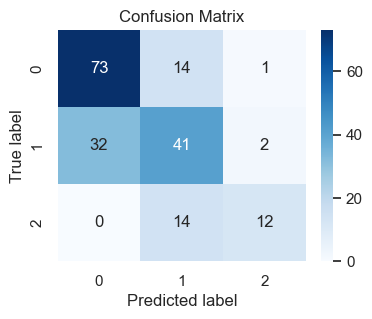

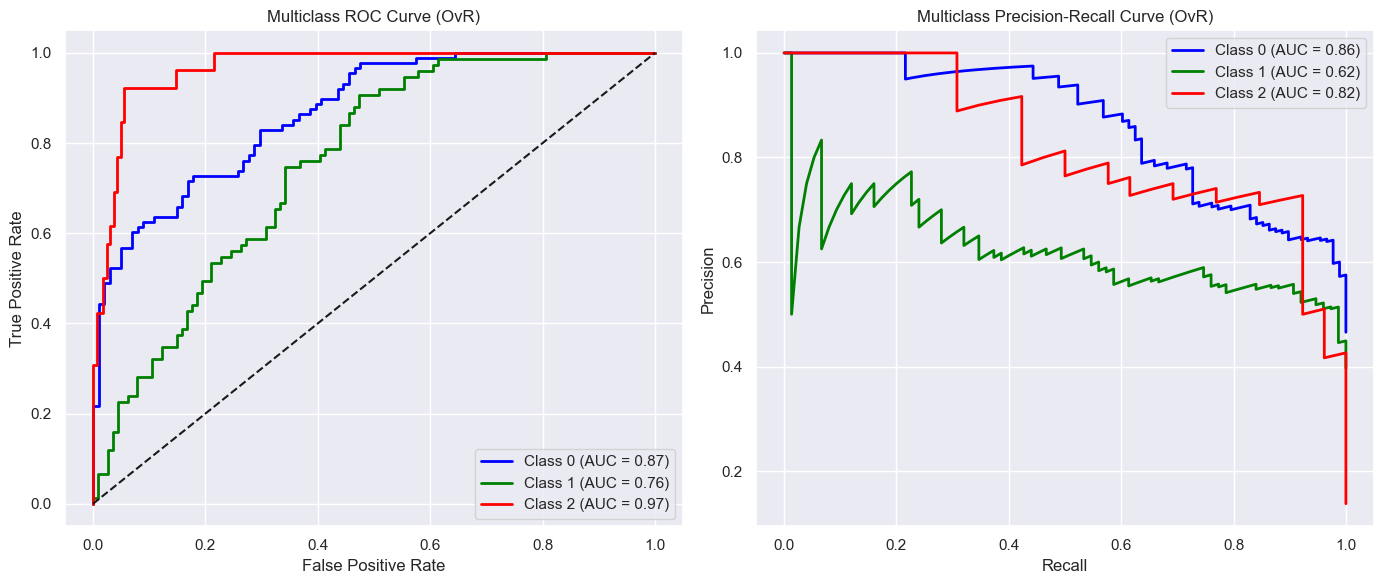

In [92]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(3, 50)),
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=10,
    scoring='roc_auc_ovo',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC on training set:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

calculate_evaluation_metrics(best_model, y_test, y_pred, y_pred_proba)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.86      0.78        88
           1       0.62      0.56      0.59        75
           2       0.85      0.42      0.56        26

    accuracy                           0.68       189
   macro avg       0.72      0.62      0.64       189
weighted avg       0.69      0.68      0.67       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8742814802911288
PR AUC: 0.7936850462415886


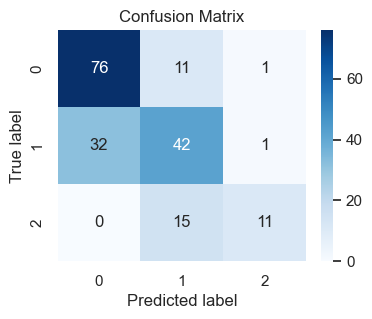

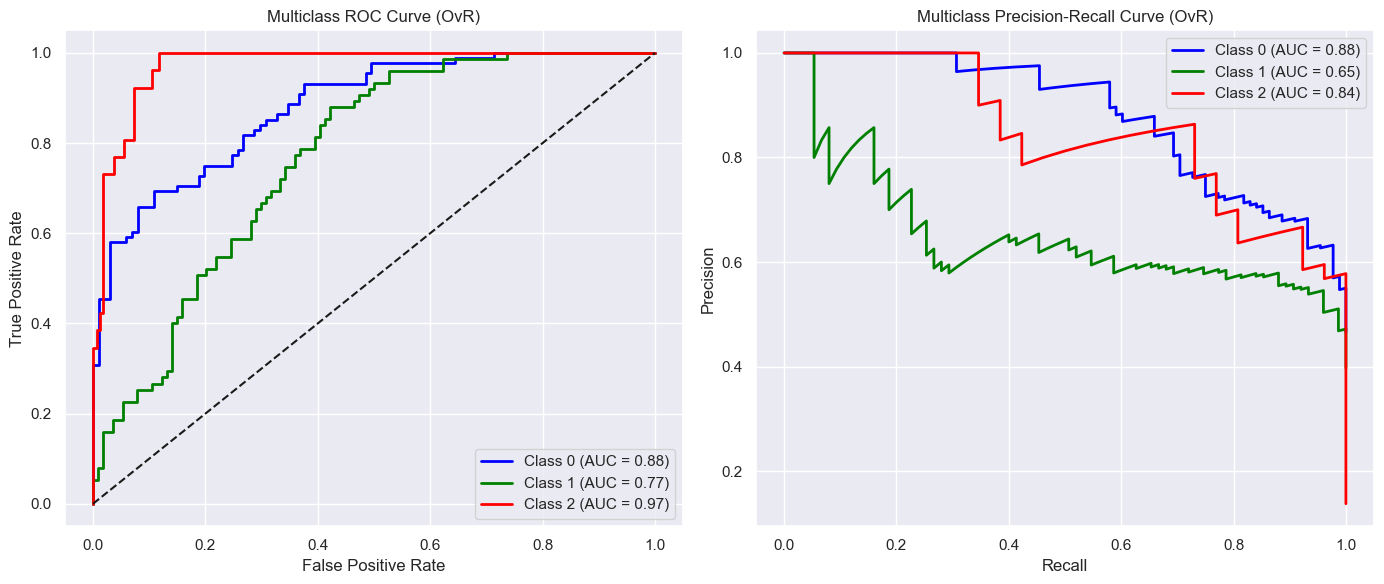


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       163
           1       0.83      0.58      0.68        26

    accuracy                           0.93       189
   macro avg       0.88      0.78      0.82       189
weighted avg       0.92      0.93      0.92       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9495044832468145
PR AUC: 0.8005956101648161


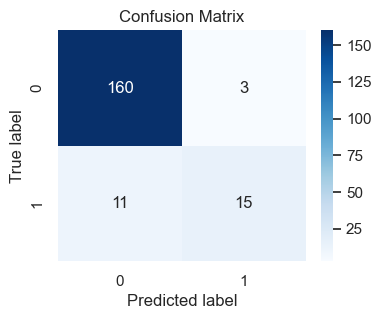

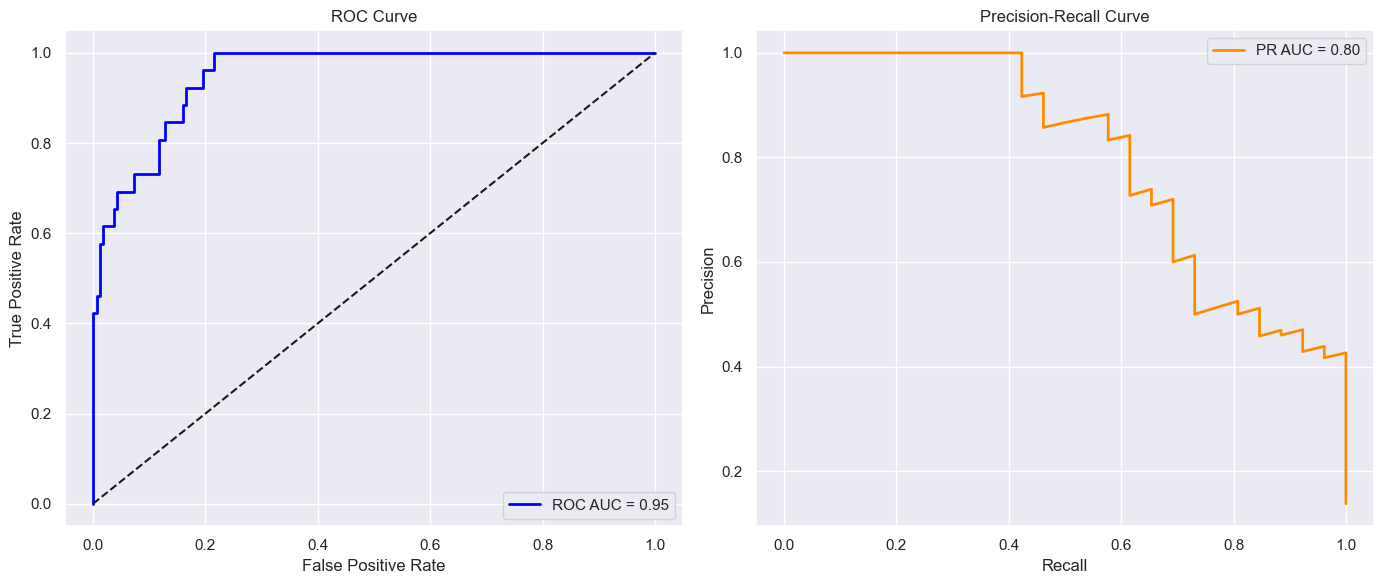


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       114
           1       0.66      0.61      0.63        75

    accuracy                           0.72       189
   macro avg       0.71      0.70      0.70       189
weighted avg       0.72      0.72      0.72       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.758421052631579
PR AUC: 0.6202481695077229


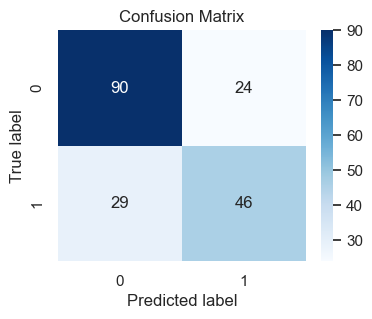

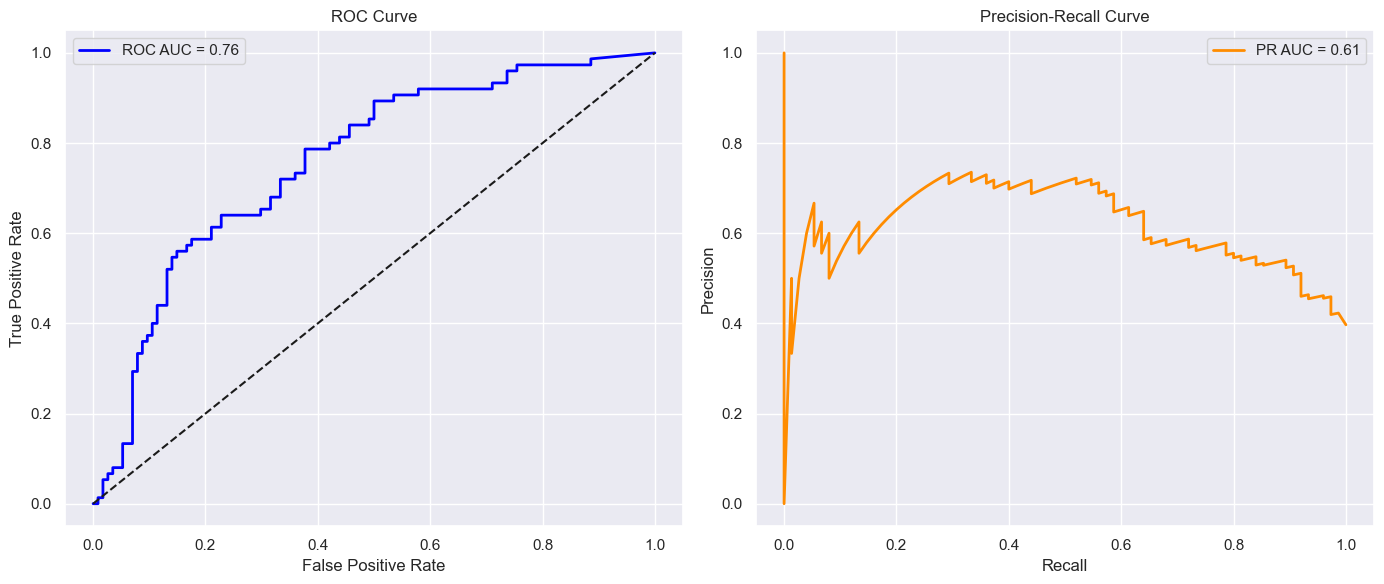


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.79      0.76      0.77       101
           1       0.74      0.76      0.75        88

    accuracy                           0.76       189
   macro avg       0.76      0.76      0.76       189
weighted avg       0.76      0.76      0.76       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8524977497749775
PR AUC: 0.8147855141832985


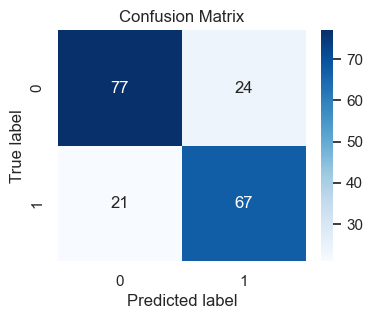

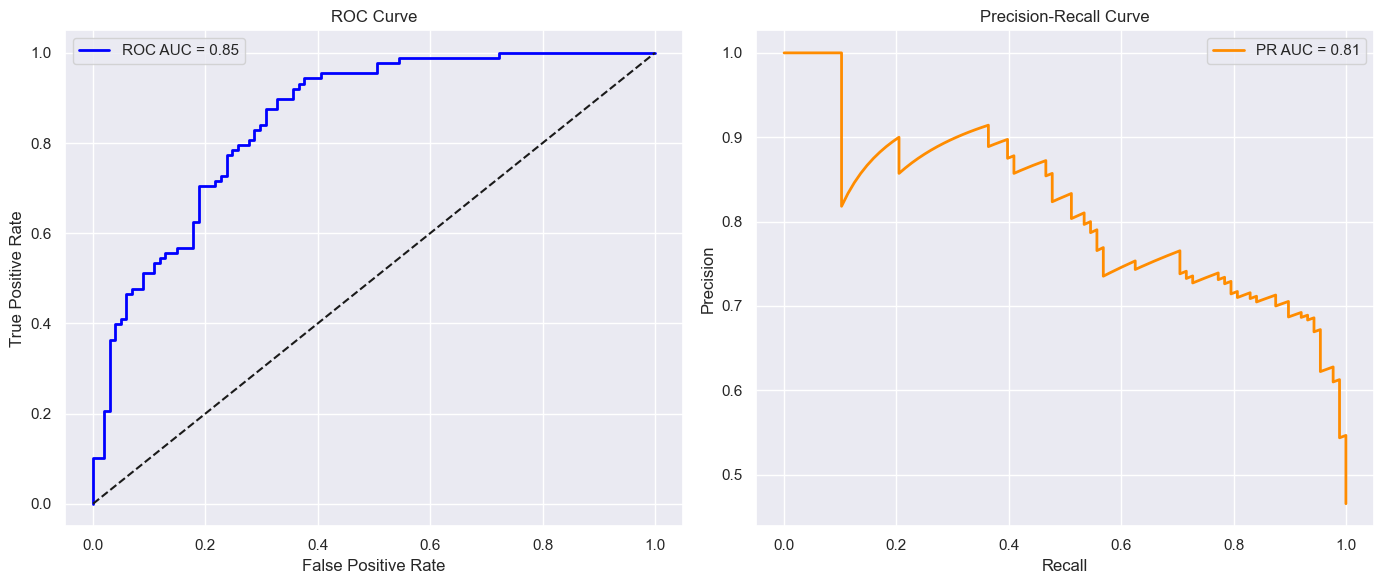

In [99]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)

calculate_evaluation_metrics(knn, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = knn_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

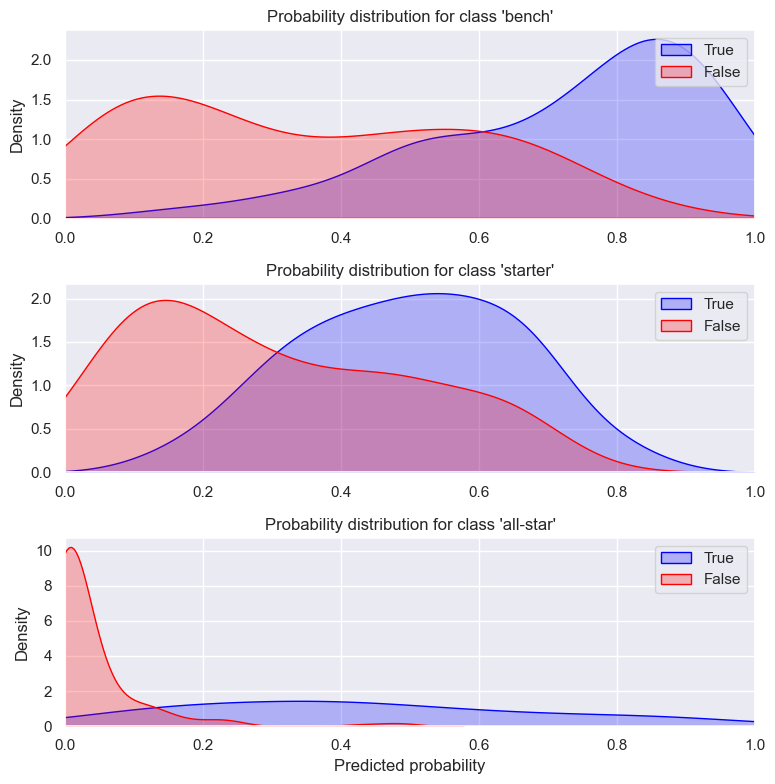

PermutationExplainer explainer: 190it [09:40,  3.09s/it]                         


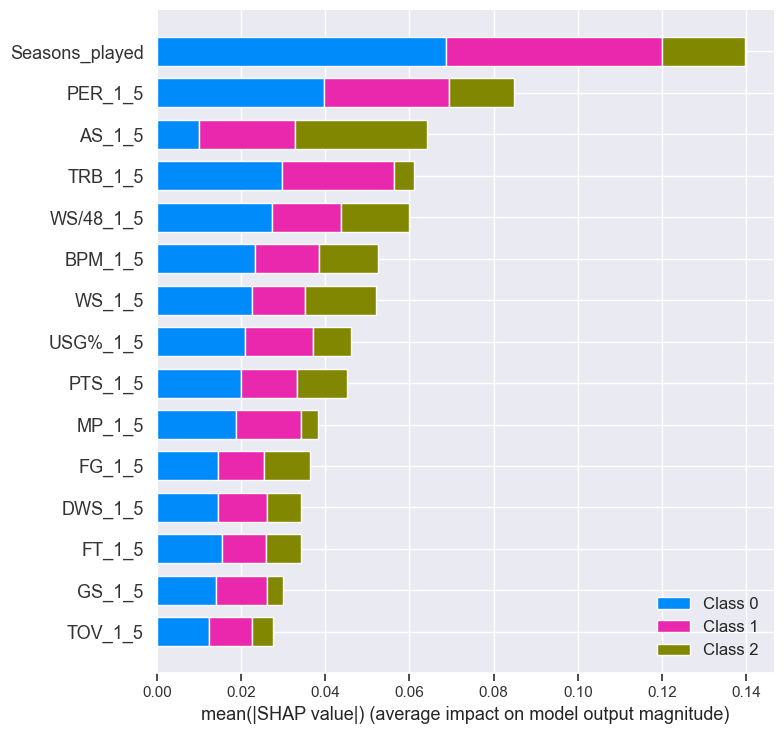

In [101]:
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_plot(knn, X_train, X_test)

In [100]:
display_lime_plot(knn, X_train, X_test, 0)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.79      0.70      0.75        88
           1       0.63      0.69      0.66        75
           2       0.71      0.77      0.74        26

    accuracy                           0.71       189
   macro avg       0.71      0.72      0.72       189
weighted avg       0.72      0.71      0.71       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8742814802911288
PR AUC: 0.7936850462415886


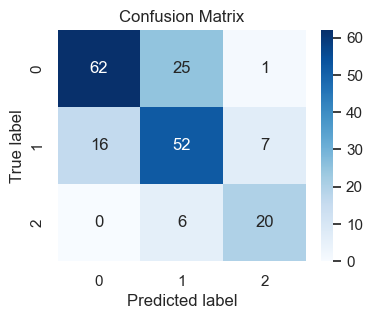

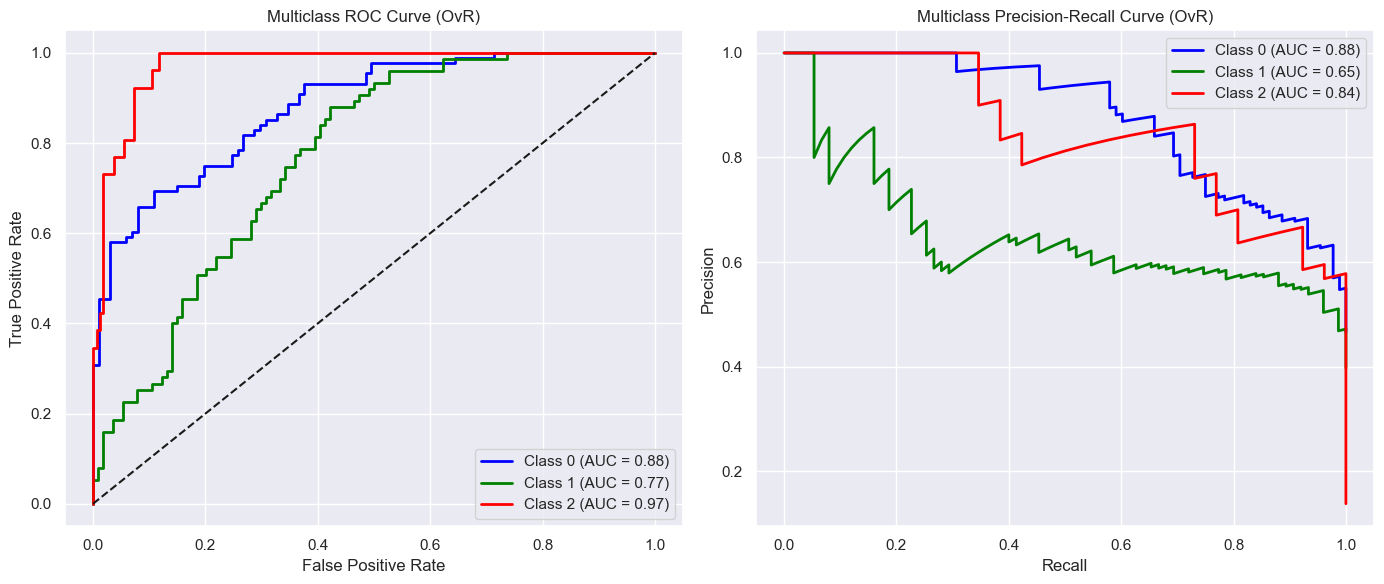


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       163
           1       0.73      0.62      0.67        26

    accuracy                           0.92       189
   macro avg       0.83      0.79      0.81       189
weighted avg       0.91      0.92      0.91       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9495044832468145
PR AUC: 0.8005956101648161


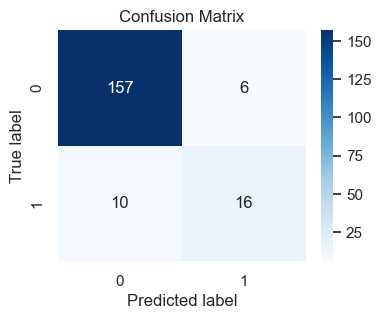

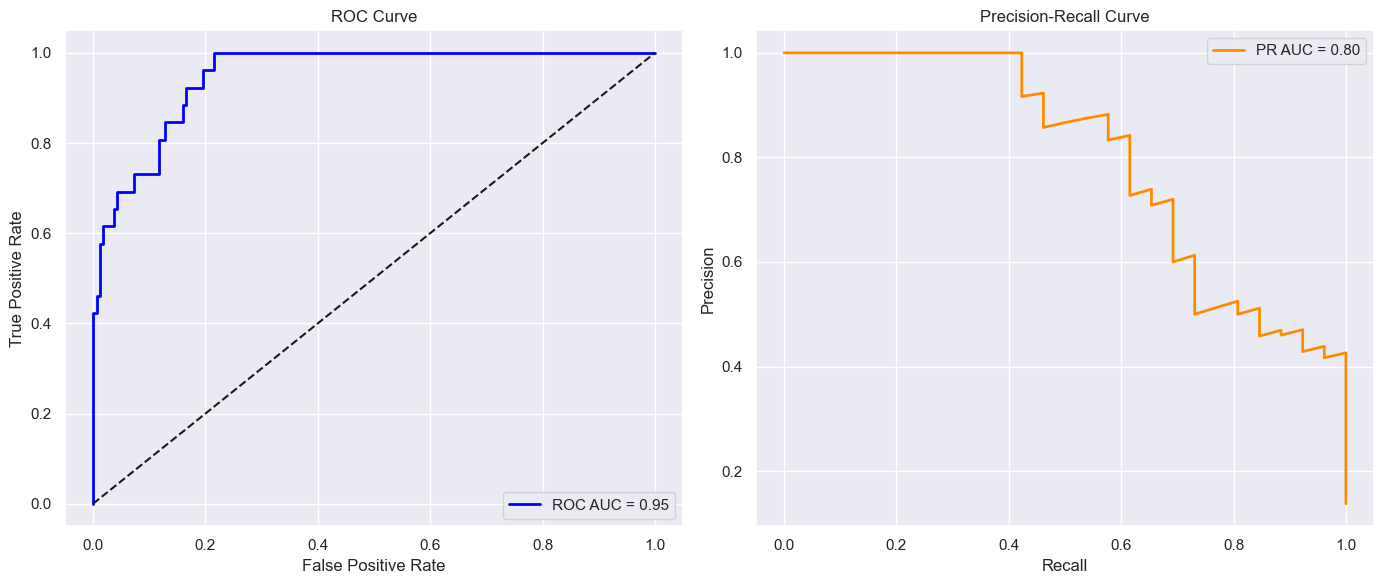


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.64      0.70       114
           1       0.57      0.72      0.64        75

    accuracy                           0.67       189
   macro avg       0.67      0.68      0.67       189
weighted avg       0.69      0.67      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.758421052631579
PR AUC: 0.6202481695077229


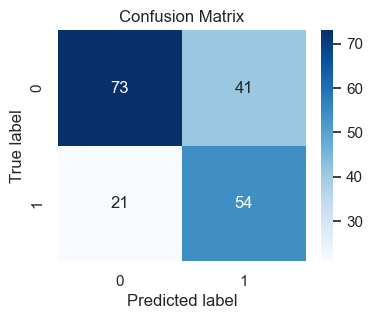

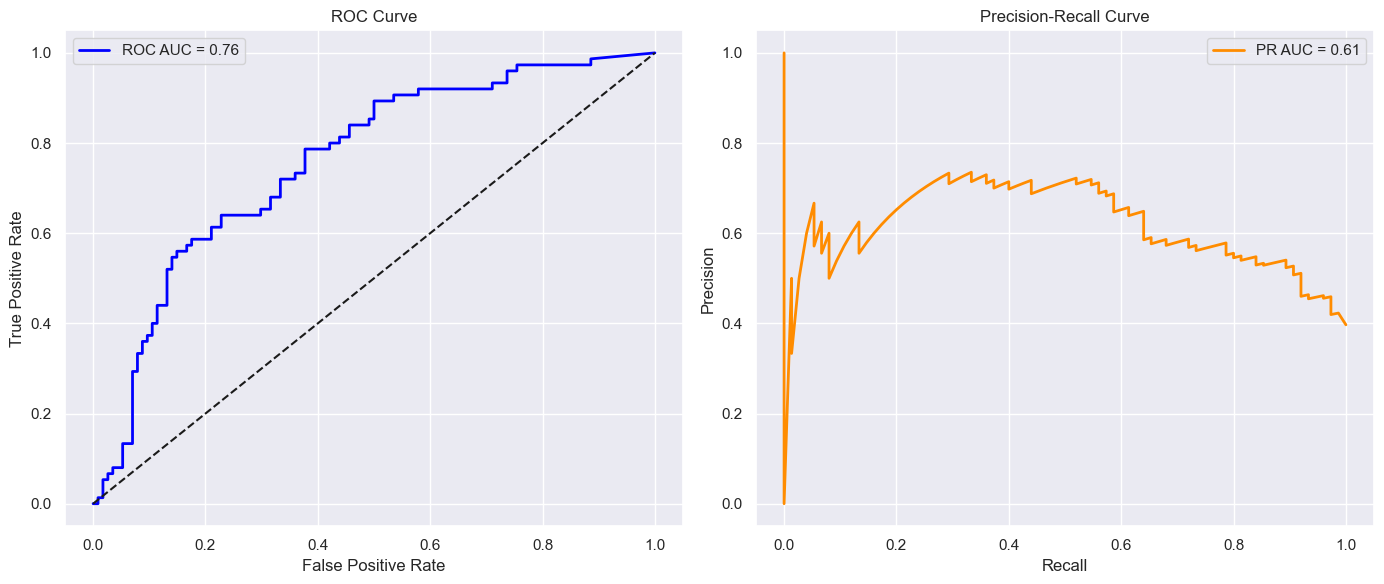


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.86      0.69      0.77       101
           1       0.71      0.88      0.79        88

    accuracy                           0.78       189
   macro avg       0.79      0.78      0.78       189
weighted avg       0.79      0.78      0.78       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8524977497749775
PR AUC: 0.8147855141832985


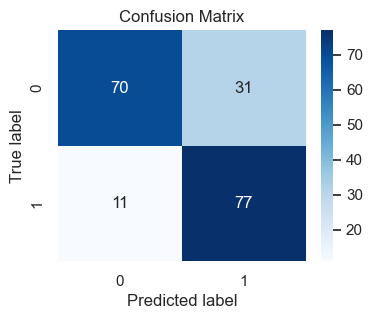

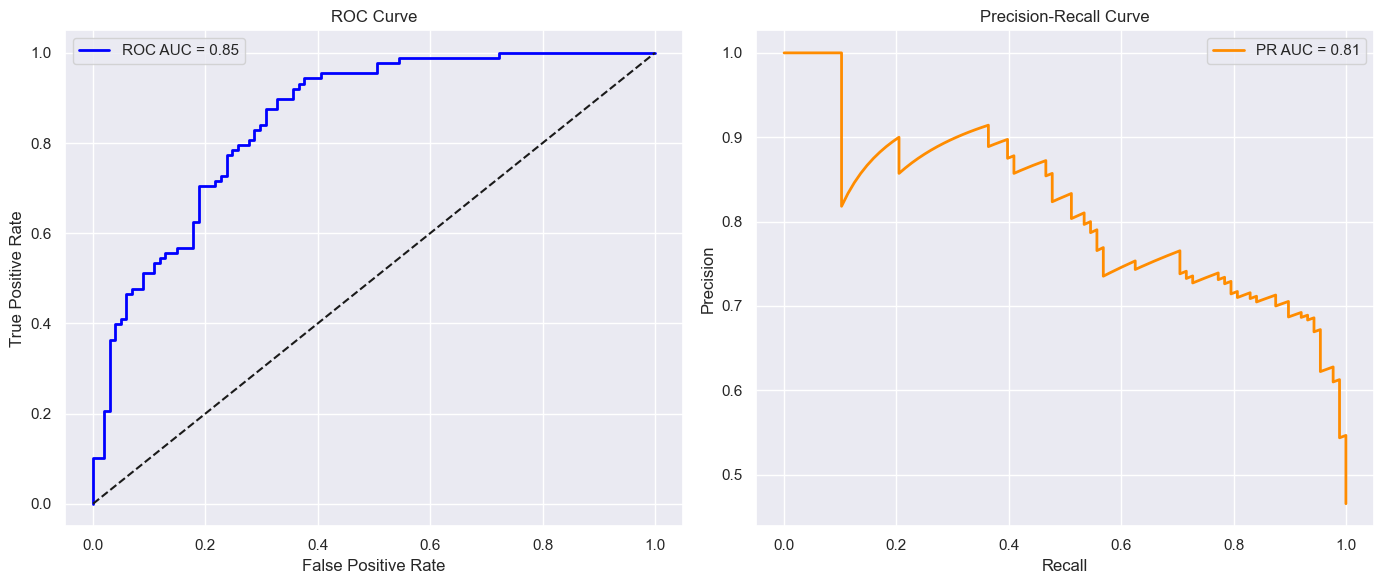

In [86]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])
ovr = OneVsRestClassifier(knn)
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.2:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)
    y_pred_bin = (y_pred_proba_bin[:,1] >= 0.4).astype(int)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.81      0.75        88
           1       0.64      0.49      0.56        75
           2       0.67      0.77      0.71        26

    accuracy                           0.68       189
   macro avg       0.67      0.69      0.67       189
weighted avg       0.67      0.68      0.67       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8784992693195618
PR AUC: 0.7869132686535861


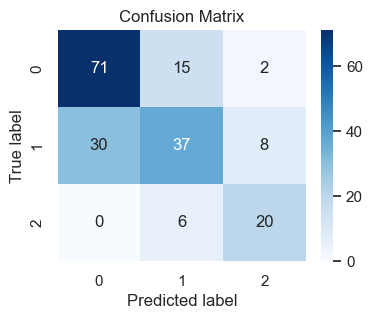

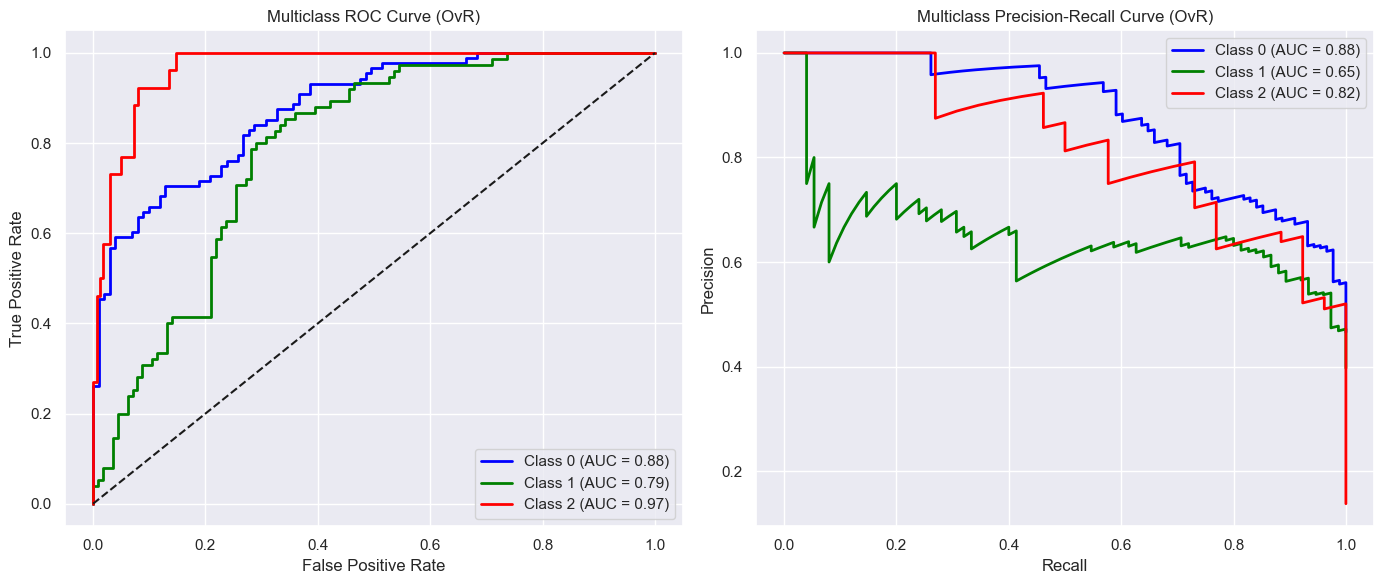

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.98      0.82      0.89       163
           1       0.43      0.88      0.58        26

    accuracy                           0.83       189
   macro avg       0.71      0.85      0.74       189
weighted avg       0.90      0.83      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.9353468617272298
PR AUC: 0.6873240917933455


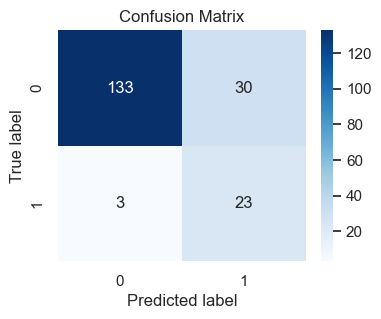

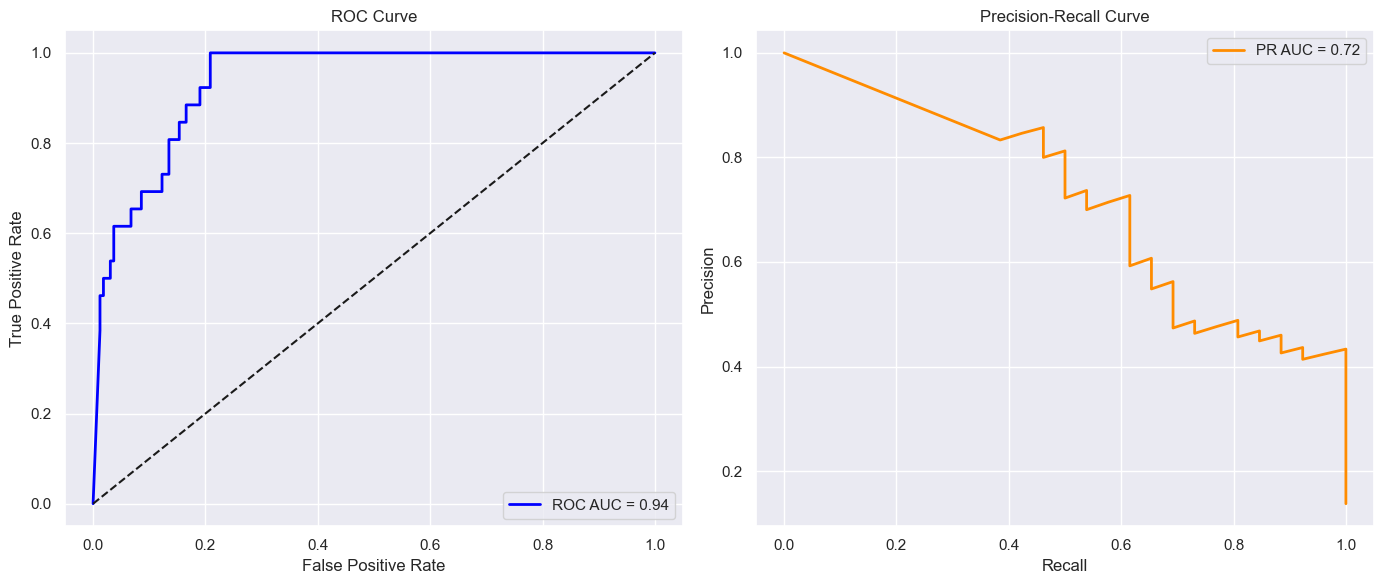

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.65      0.72       114
           1       0.59      0.76      0.66        75

    accuracy                           0.69       189
   macro avg       0.70      0.70      0.69       189
weighted avg       0.72      0.69      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7719298245614036
PR AUC: 0.639188954592832


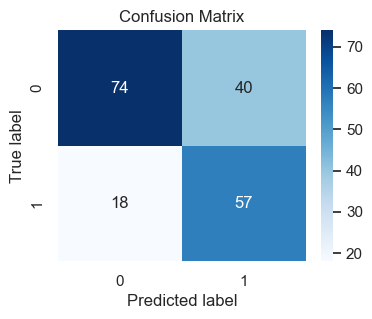

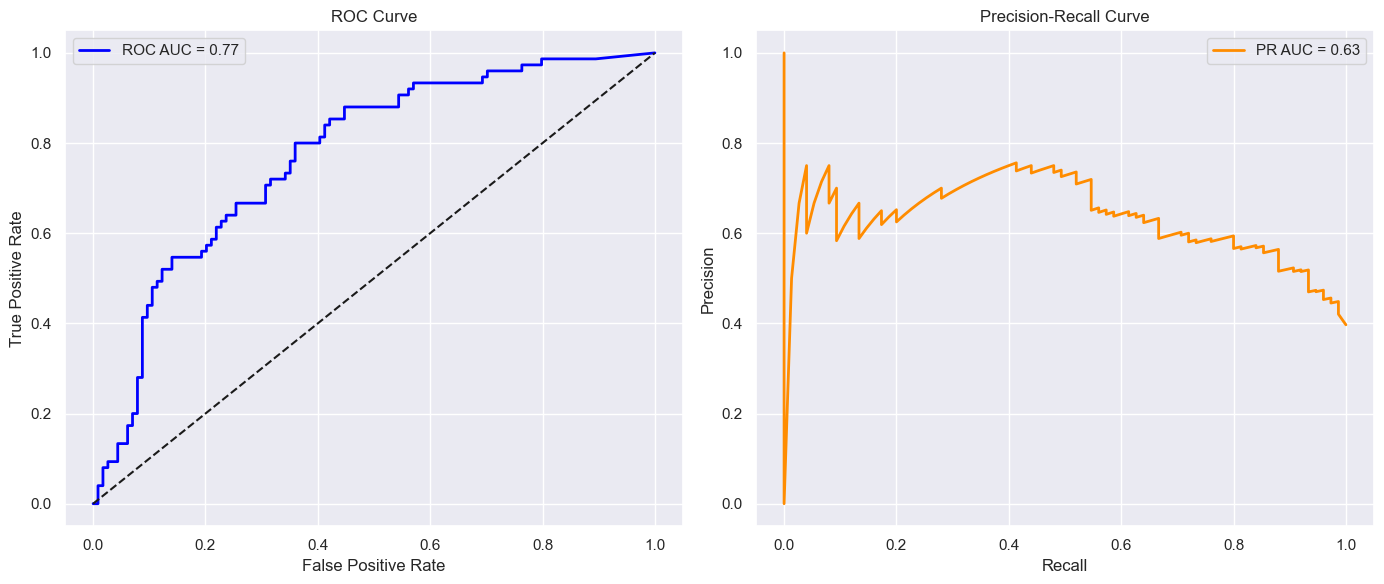

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       101
           1       0.73      0.78      0.75        88

    accuracy                           0.76       189
   macro avg       0.76      0.76      0.76       189
weighted avg       0.76      0.76      0.76       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8512601260126014
PR AUC: 0.8123116115731387


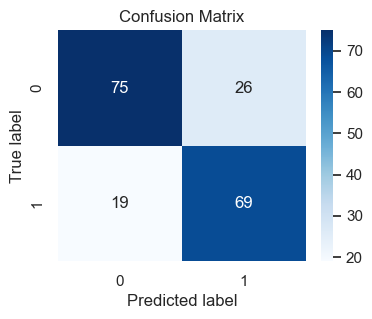

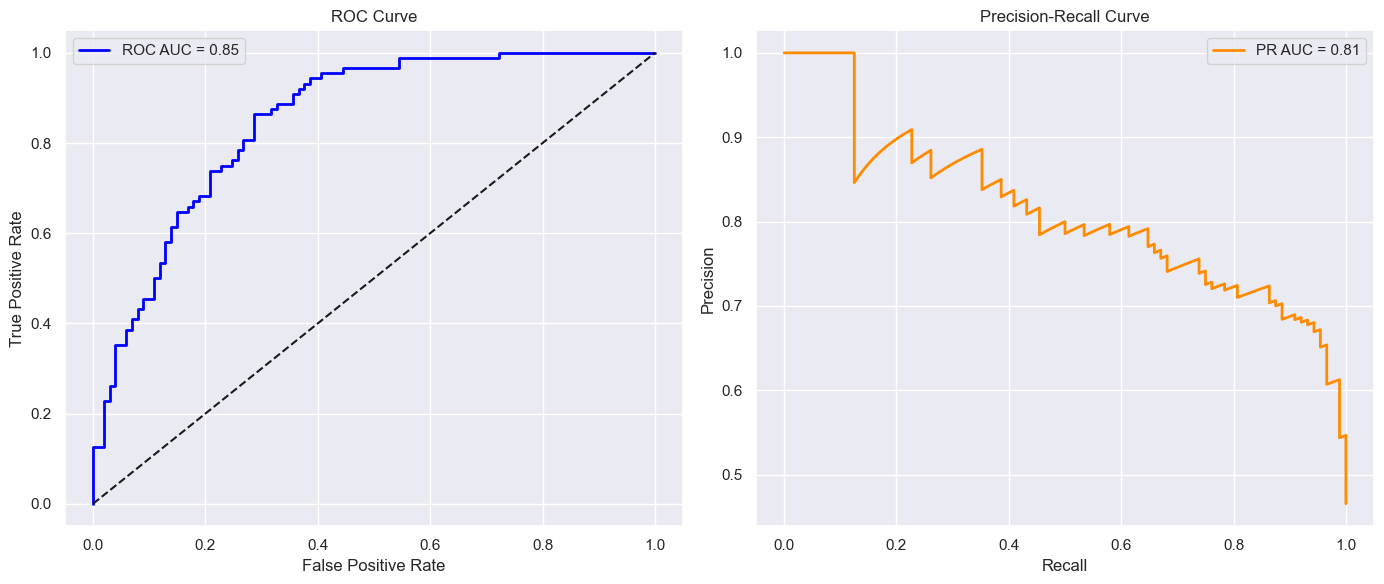

In [3]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

knn_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn_smote.fit(X_res, y_res)

y_pred = knn_smote.predict(X_test)
y_pred_proba = knn_smote.predict_proba(X_test)

calculate_evaluation_metrics(knn_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_5_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res).value_counts())

    knn_smote_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_smote_bin.fit(X_res, y_res)

    y_pred_bin = knn_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

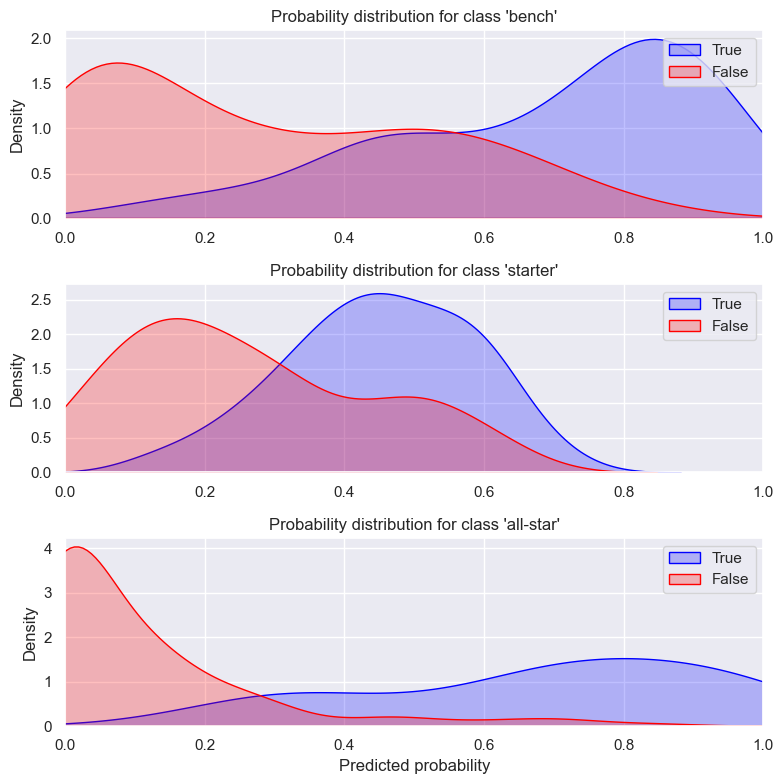

PermutationExplainer explainer: 190it [13:16,  4.21s/it]                         


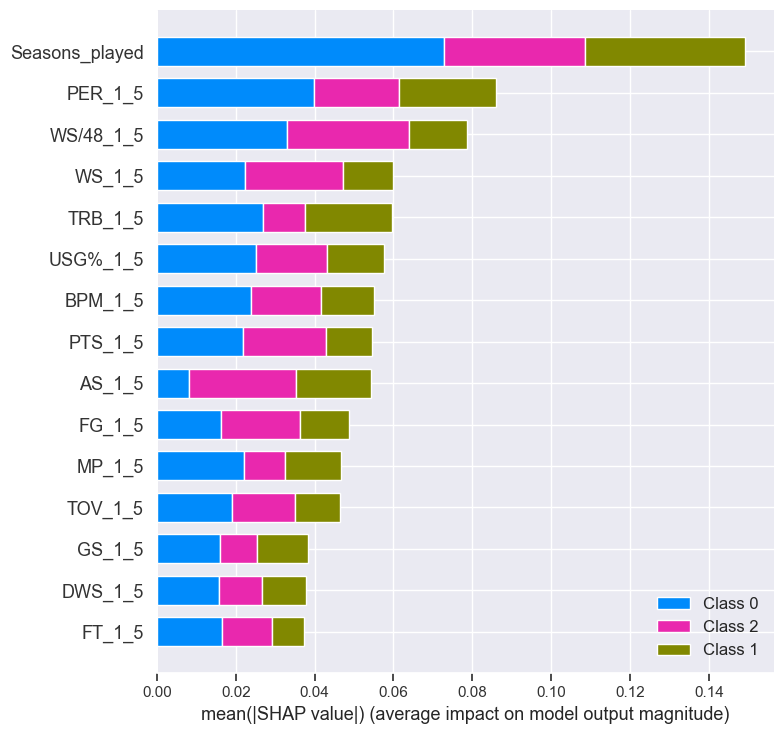

In [5]:
plot_class_probability_distributions(y_test, y_pred_proba)
display_shap_plot(knn_smote, X_train, X_test)

In [6]:
display_lime_plot(knn_smote, X_train, X_test, 0)

<h3>Classification results, input: statistics from the <b>first 3</b> seasons</h3>

In [16]:
df_3 = pd.read_csv('data/final_dataset_3_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_3['Player_class_num'] = df_3['Player_class'].map(class_mapping)

final_dataset_3_seasons = df_3[get_selected_features(3)]

X = final_dataset_3_seasons.drop(columns=['Player_class_num'])
y = final_dataset_3_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.88      0.78        88
           1       0.57      0.55      0.56        75
           2       0.86      0.23      0.36        26

    accuracy                           0.66       189
   macro avg       0.71      0.55      0.57       189
weighted avg       0.67      0.66      0.63       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8253719339793695
PR AUC: 0.6994760563329473


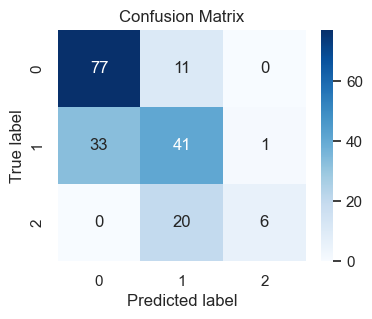

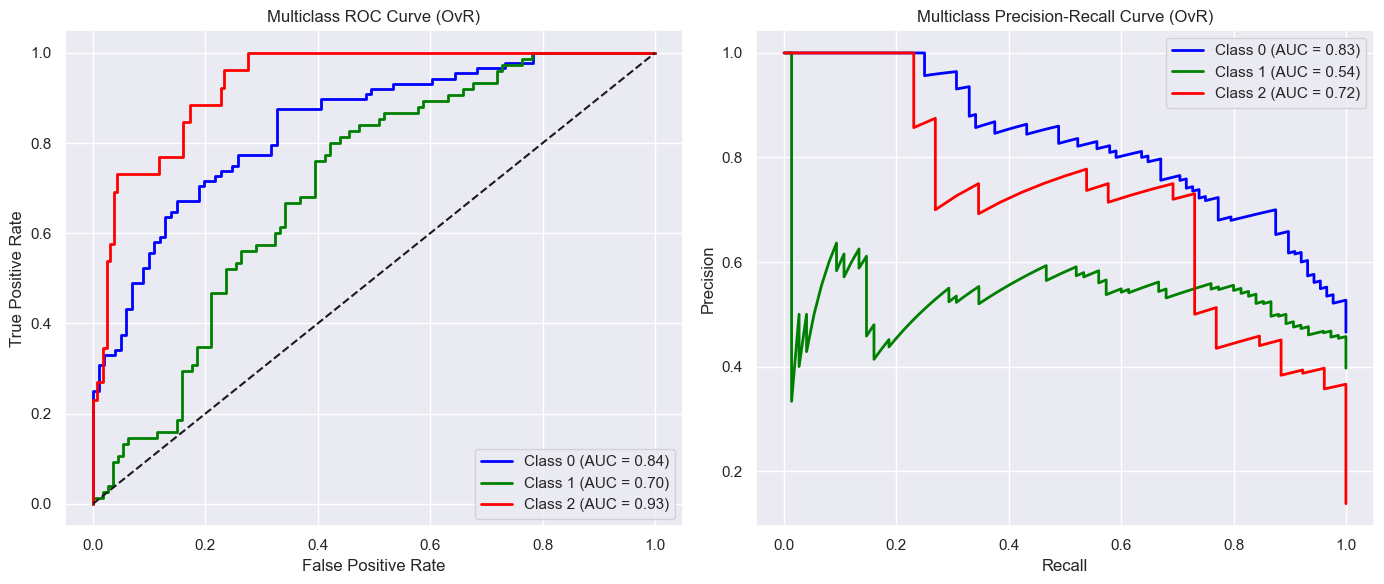


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       163
           1       0.64      0.35      0.45        26

    accuracy                           0.88       189
   macro avg       0.77      0.66      0.69       189
weighted avg       0.87      0.88      0.87       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8732892873997169
PR AUC: 0.6103437929015296


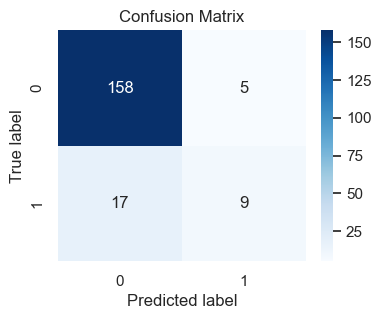

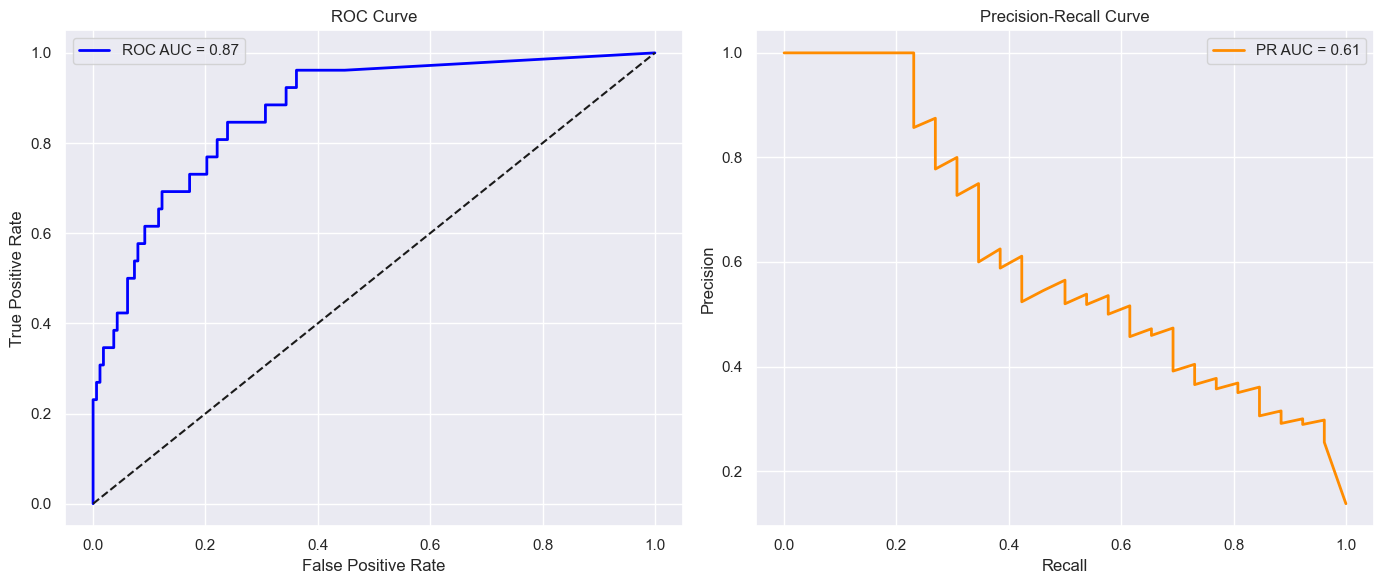


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.68      0.74      0.71       114
           1       0.55      0.48      0.51        75

    accuracy                           0.63       189
   macro avg       0.61      0.61      0.61       189
weighted avg       0.63      0.63      0.63       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.707485380116959
PR AUC: 0.5763049612694203


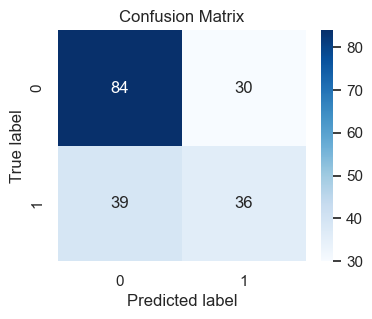

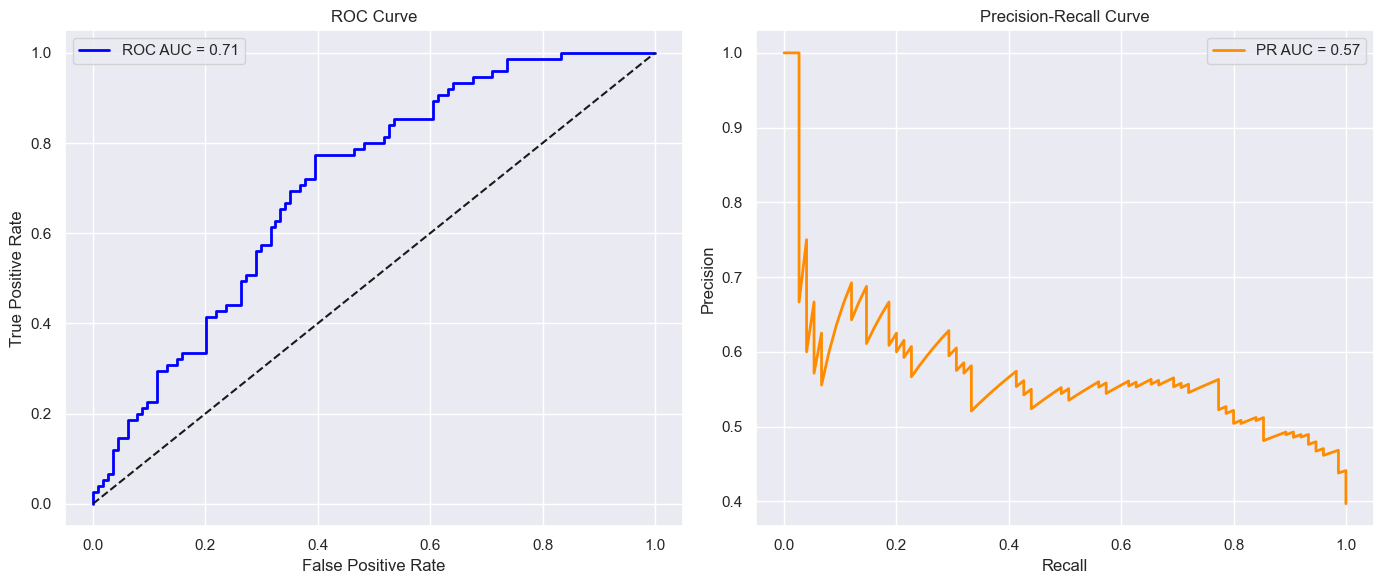


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.73      0.74      0.74       101
           1       0.70      0.68      0.69        88

    accuracy                           0.71       189
   macro avg       0.71      0.71      0.71       189
weighted avg       0.71      0.71      0.71       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7975922592259226
PR AUC: 0.744067116270794


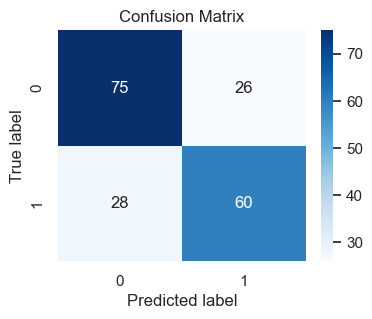

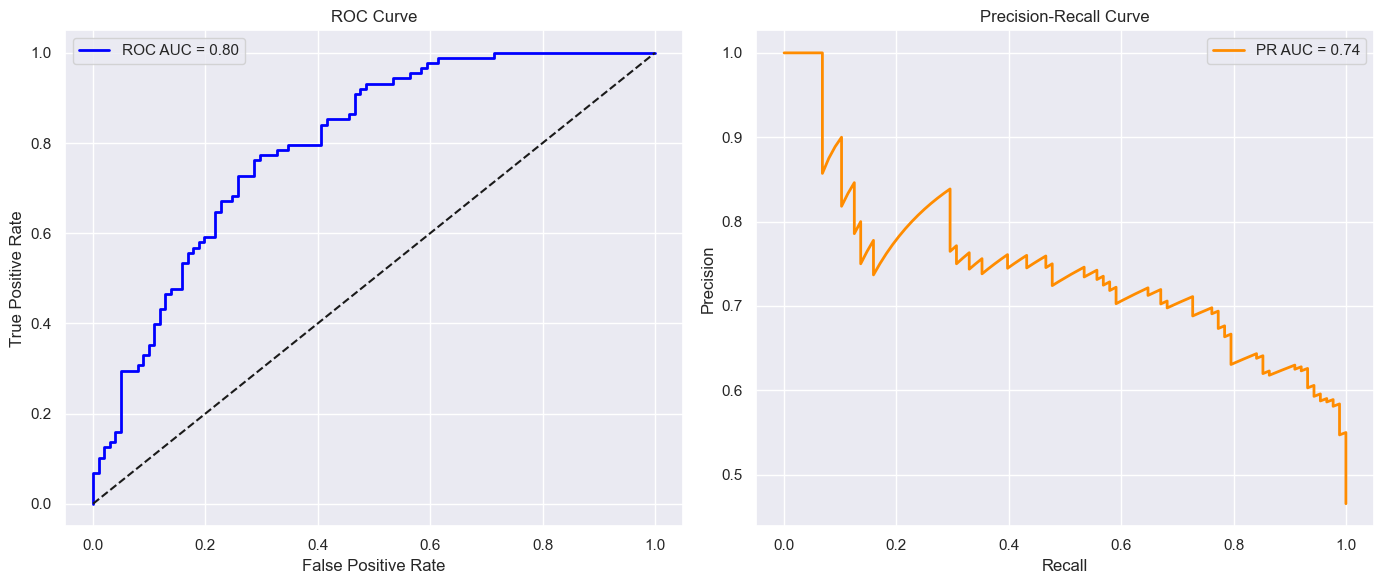

In [17]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)

calculate_evaluation_metrics(knn, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = knn_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.81      0.64      0.71        88
           1       0.60      0.77      0.68        75
           2       0.75      0.69      0.72        26

    accuracy                           0.70       189
   macro avg       0.72      0.70      0.70       189
weighted avg       0.72      0.70      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8253719339793695
PR AUC: 0.6994760563329473


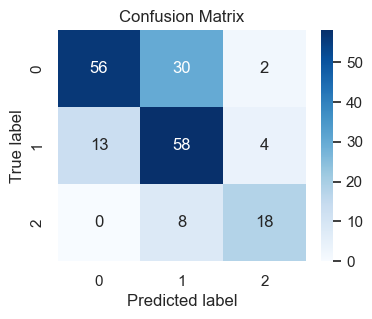

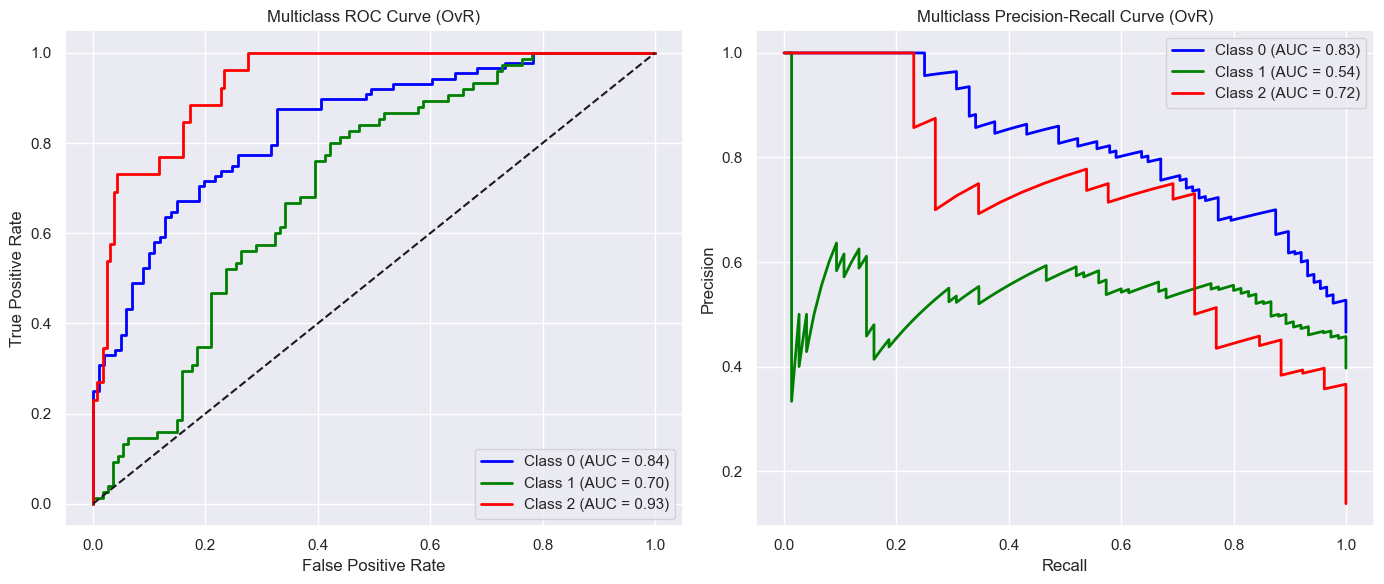


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       163
           1       0.58      0.42      0.49        26

    accuracy                           0.88       189
   macro avg       0.75      0.69      0.71       189
weighted avg       0.87      0.88      0.87       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8732892873997169
PR AUC: 0.6103437929015296


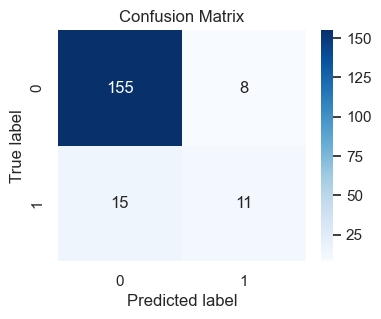

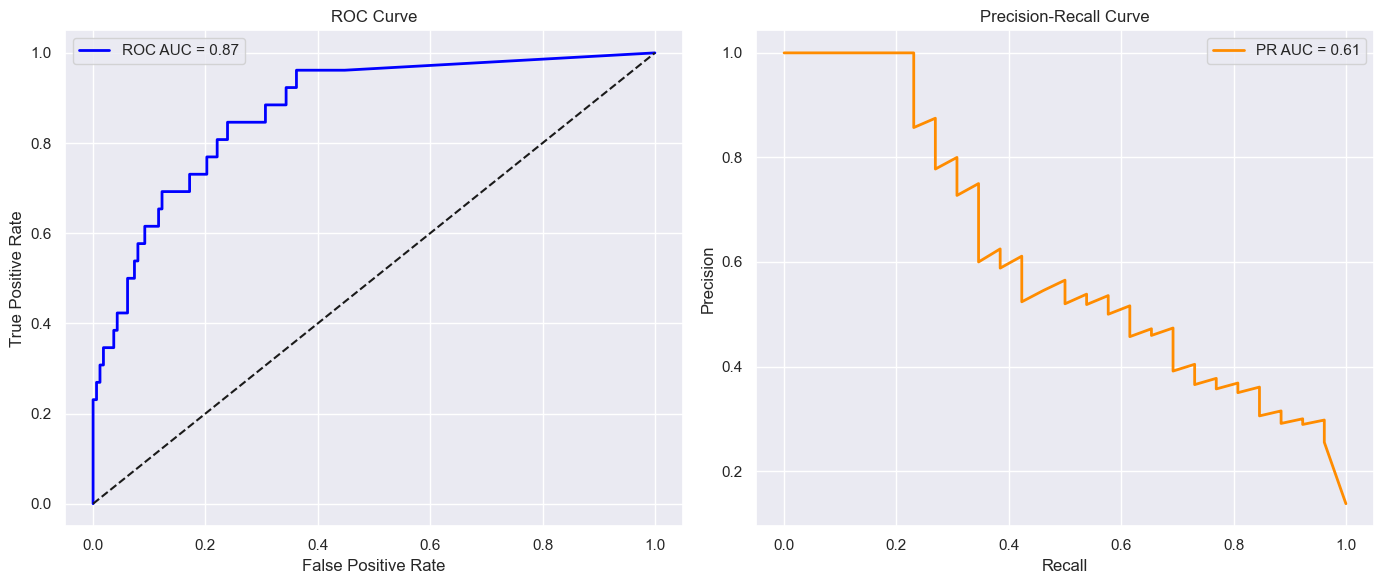


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.61      0.68       114
           1       0.55      0.73      0.63        75

    accuracy                           0.66       189
   macro avg       0.66      0.67      0.65       189
weighted avg       0.69      0.66      0.66       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.707485380116959
PR AUC: 0.5763049612694203


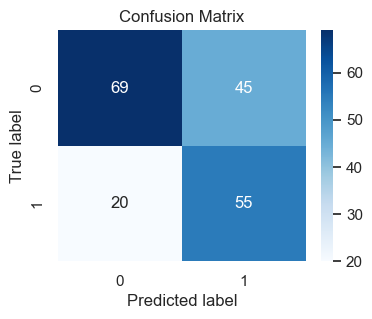

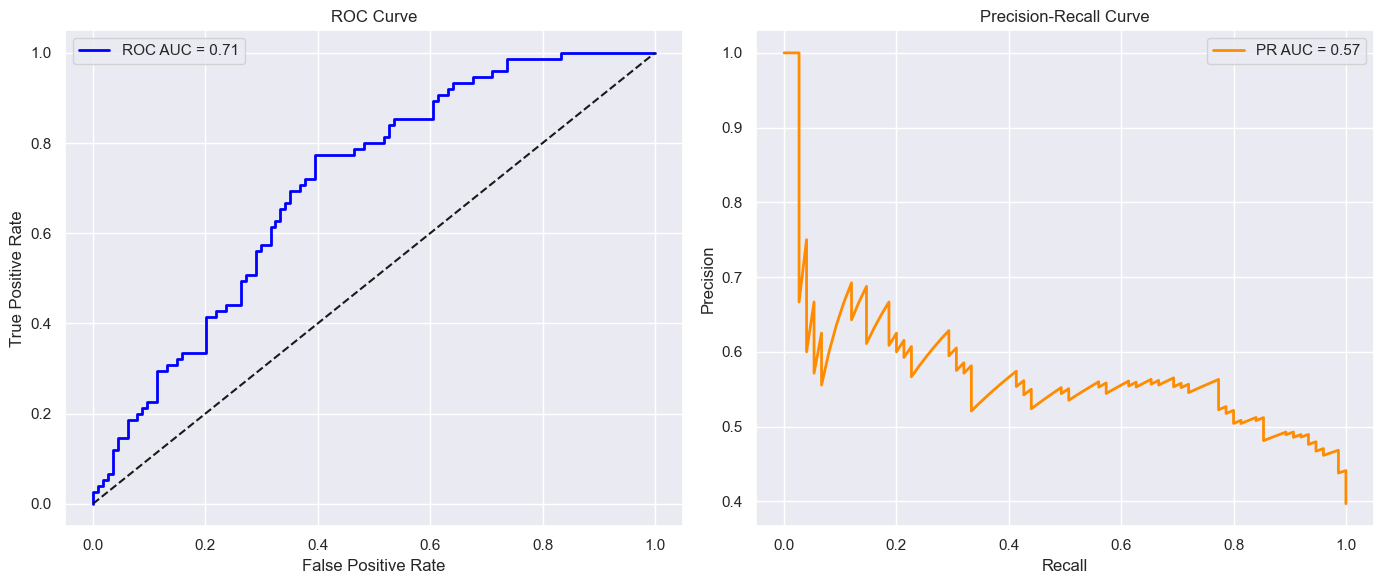


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.59      0.67       101
           1       0.63      0.81      0.71        88

    accuracy                           0.69       189
   macro avg       0.71      0.70      0.69       189
weighted avg       0.71      0.69      0.69       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7975922592259226
PR AUC: 0.744067116270794


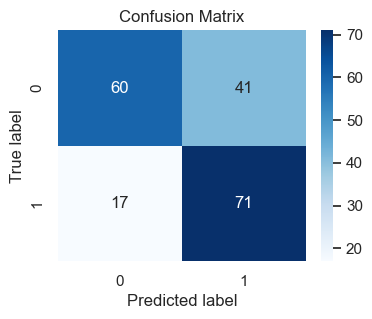

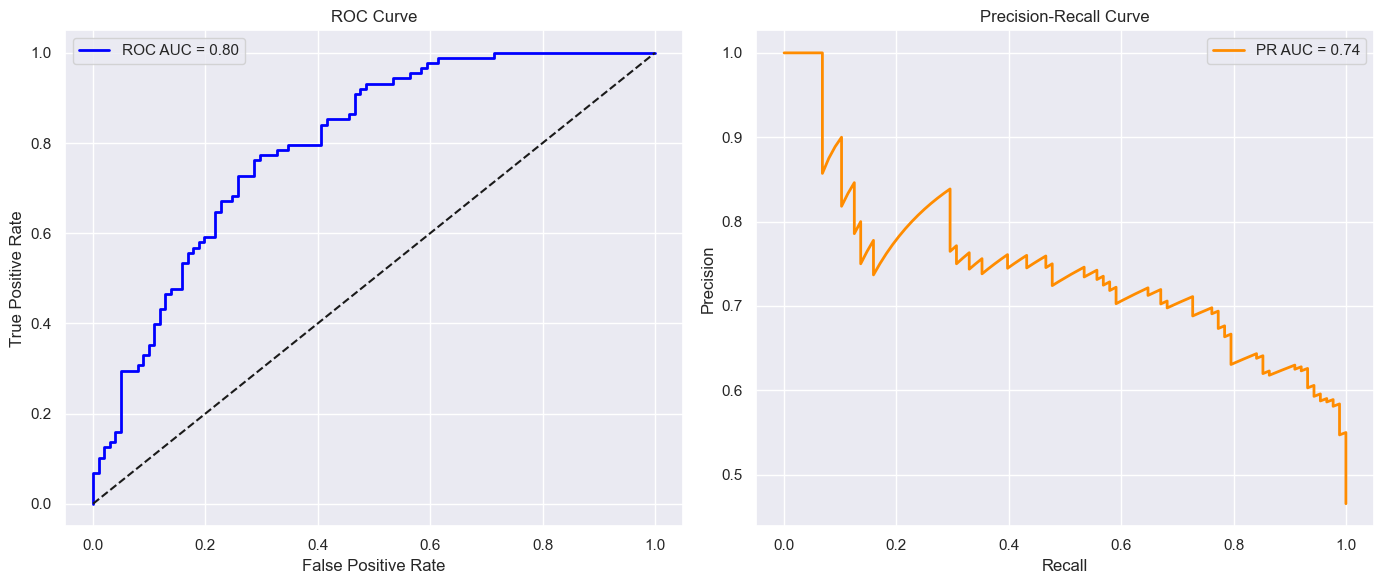

In [5]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])
ovr = OneVsRestClassifier(knn)
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.2:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)
    y_pred_bin = (y_pred_proba_bin[:,1] >= 0.4).astype(int)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.75      0.73        88
           1       0.57      0.43      0.49        75
           2       0.49      0.73      0.58        26

    accuracy                           0.62       189
   macro avg       0.59      0.64      0.60       189
weighted avg       0.62      0.62      0.61       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8257008597749239
PR AUC: 0.7044629759764839


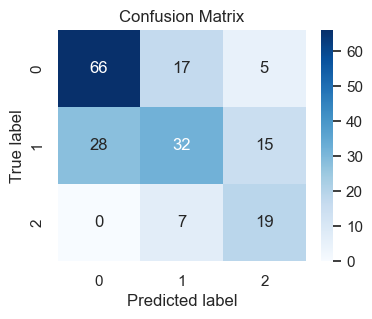

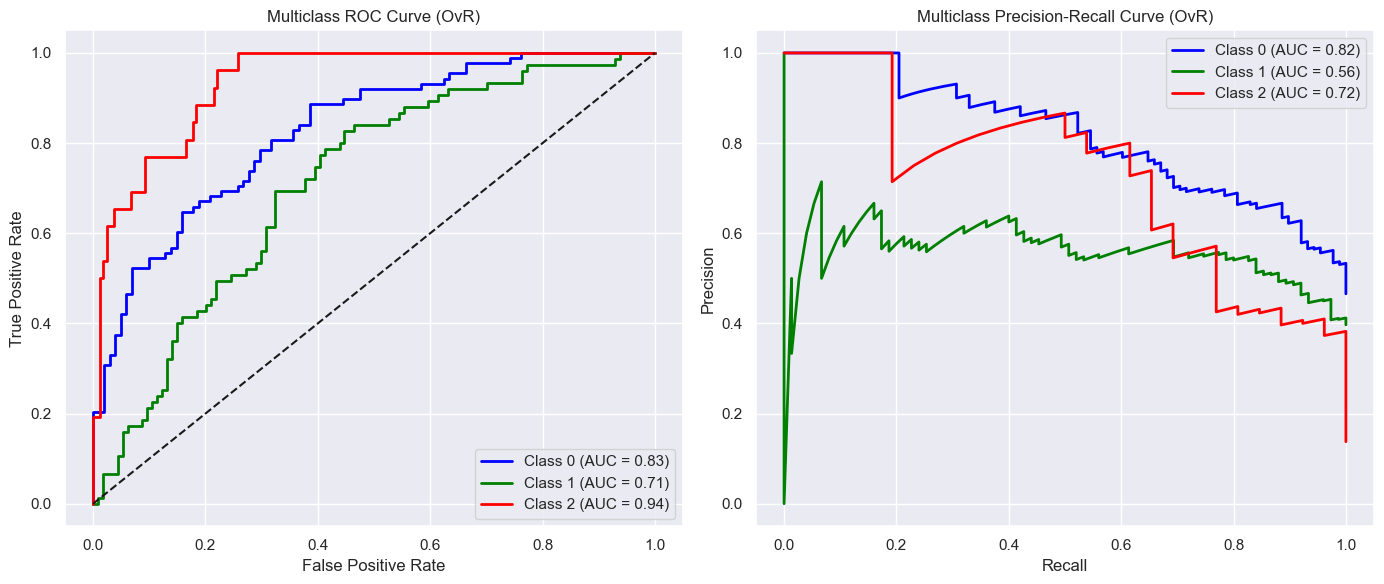

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.95      0.77      0.85       163
           1       0.34      0.77      0.48        26

    accuracy                           0.77       189
   macro avg       0.65      0.77      0.66       189
weighted avg       0.87      0.77      0.80       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8678621991505426
PR AUC: 0.46559443974448866


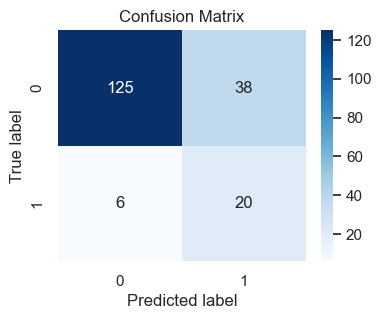

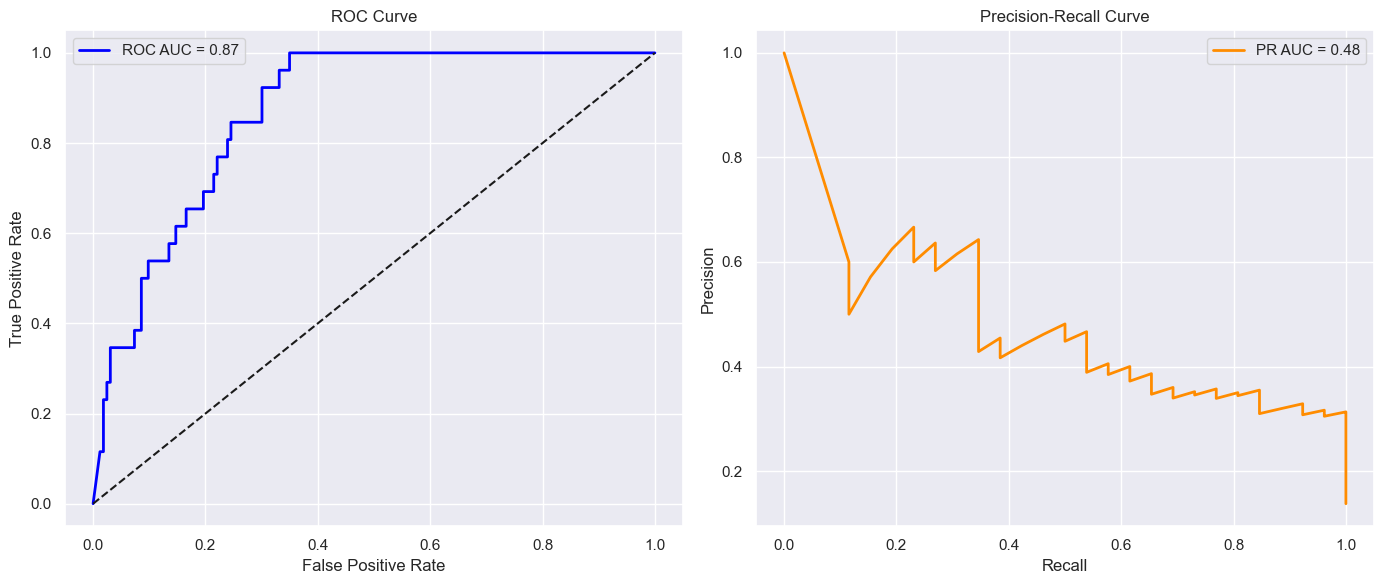

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.57      0.67       114
           1       0.55      0.79      0.64        75

    accuracy                           0.66       189
   macro avg       0.67      0.68      0.66       189
weighted avg       0.70      0.66      0.66       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6923976608187135
PR AUC: 0.5514603541436985


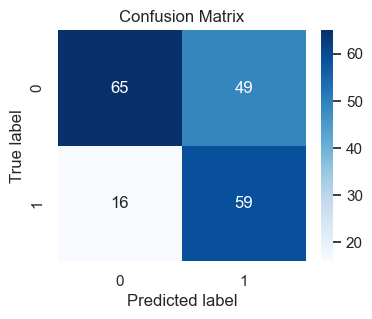

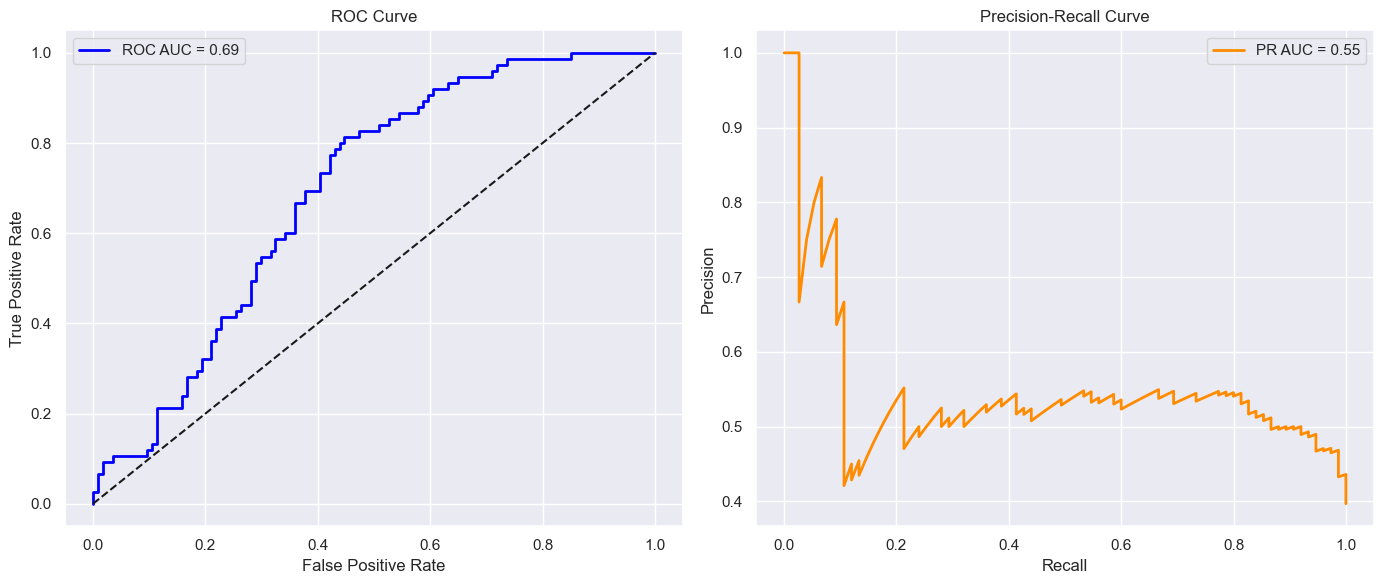

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.68      0.73       101
           1       0.68      0.77      0.72        88

    accuracy                           0.72       189
   macro avg       0.73      0.73      0.72       189
weighted avg       0.73      0.72      0.72       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.8014176417641764
PR AUC: 0.7334609093811502


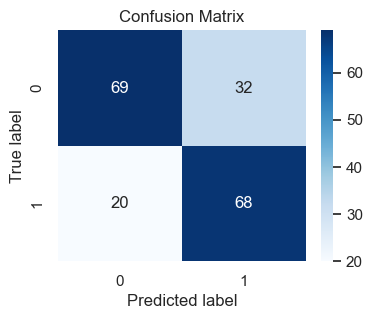

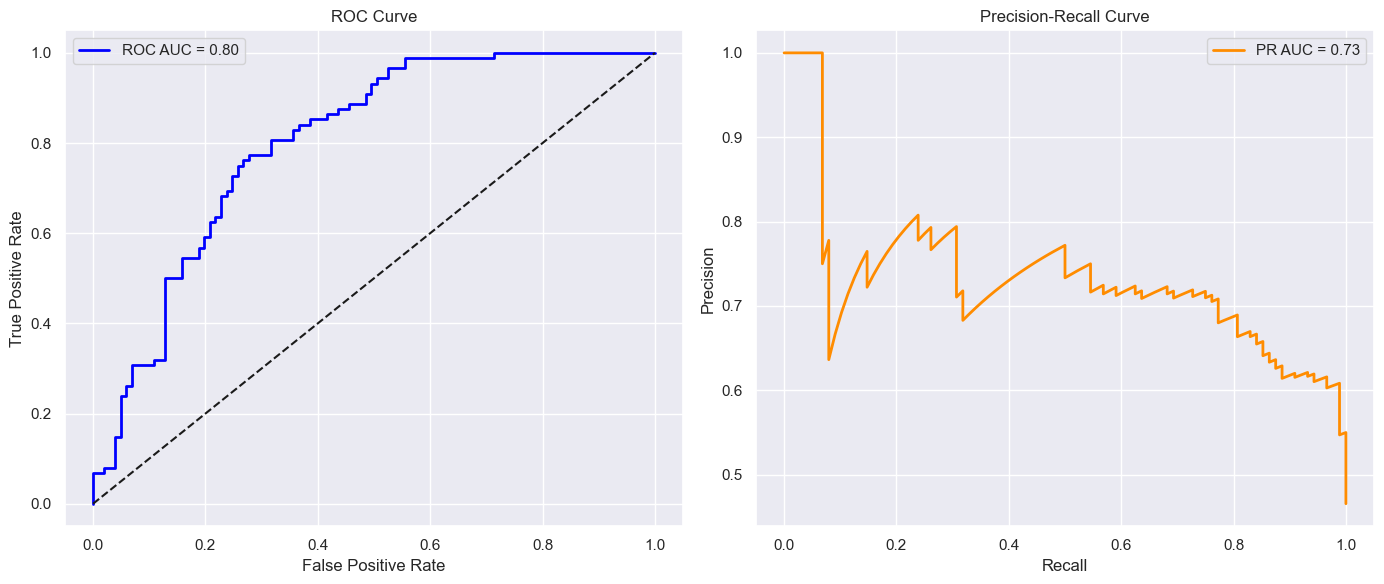

In [14]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

knn_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn_smote.fit(X_res, y_res)

y_pred = knn_smote.predict(X_test)
y_pred_proba = knn_smote.predict_proba(X_test)

calculate_evaluation_metrics(knn_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_3_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res).value_counts())

    knn_smote_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_smote_bin.fit(X_res, y_res)

    y_pred_bin = knn_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

<h3>Classification results, input: statistics from the <b>rookie</b> season</h3>

In [18]:
df_1 = pd.read_csv('data/final_dataset_1_seasons.csv', low_memory=False)

class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_1['Player_class_num'] = df_1['Player_class'].map(class_mapping)

final_dataset_1_seasons = df_1[get_selected_features(1)]

X = final_dataset_1_seasons.drop(columns=['Player_class_num'])
y = final_dataset_1_seasons['Player_class_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.64      0.80      0.71        88
           1       0.49      0.51      0.50        75
           2       1.00      0.12      0.21        26

    accuracy                           0.59       189
   macro avg       0.71      0.47      0.47       189
weighted avg       0.63      0.59      0.56       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7639530096548066
PR AUC: 0.5982454400321617


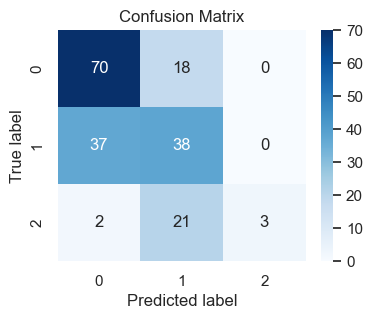

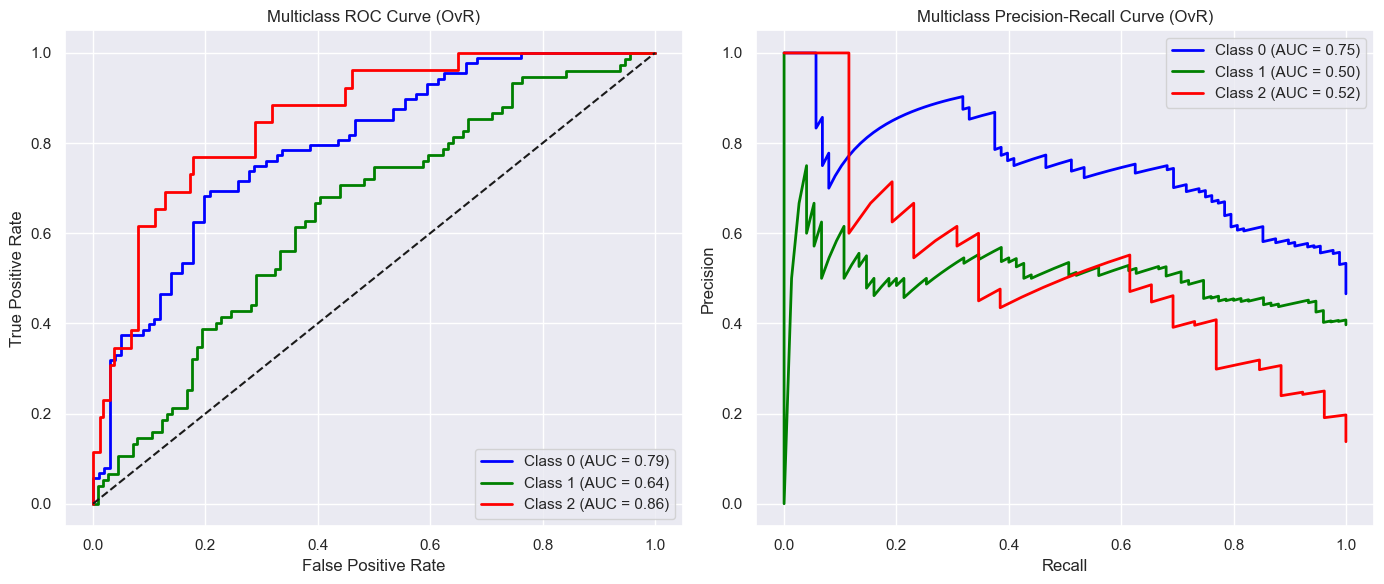


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       163
           1       1.00      0.19      0.32        26

    accuracy                           0.89       189
   macro avg       0.94      0.60      0.63       189
weighted avg       0.90      0.89      0.85       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7852760736196319
PR AUC: 0.512478706602467


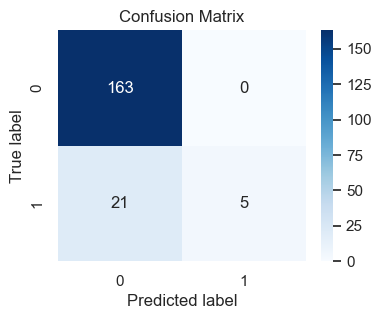

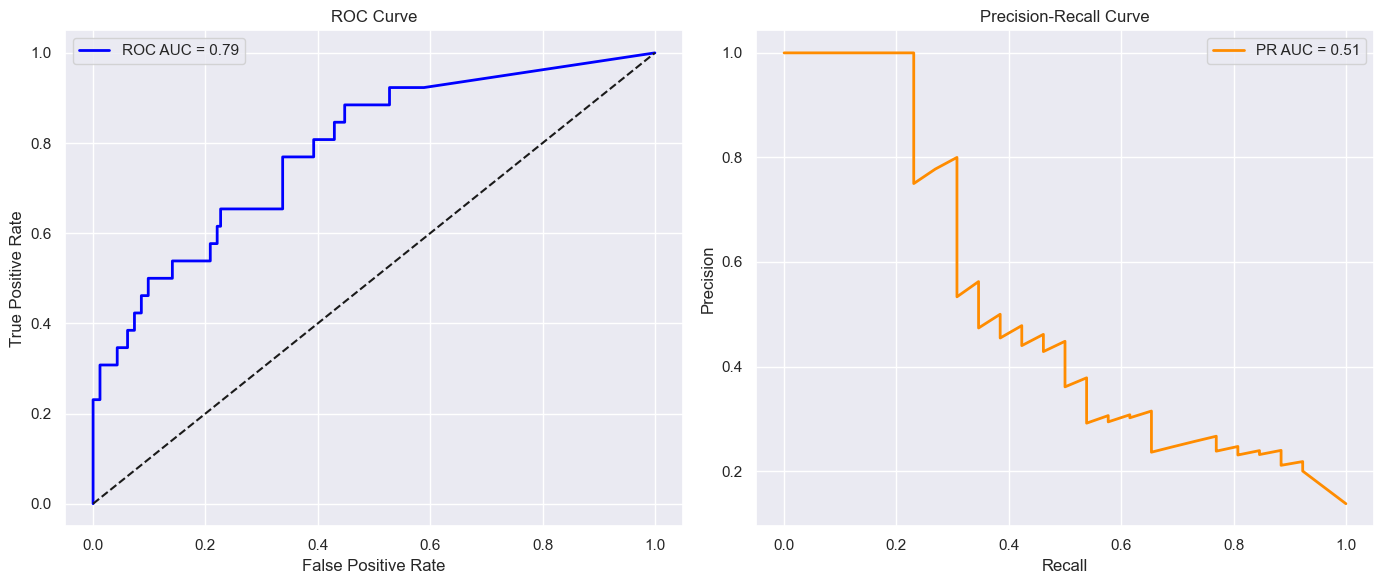


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.65      0.80      0.71       114
           1       0.52      0.33      0.41        75

    accuracy                           0.61       189
   macro avg       0.58      0.57      0.56       189
weighted avg       0.60      0.61      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6168421052631579
PR AUC: 0.49727155495255404


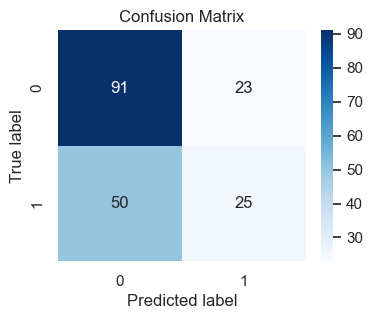

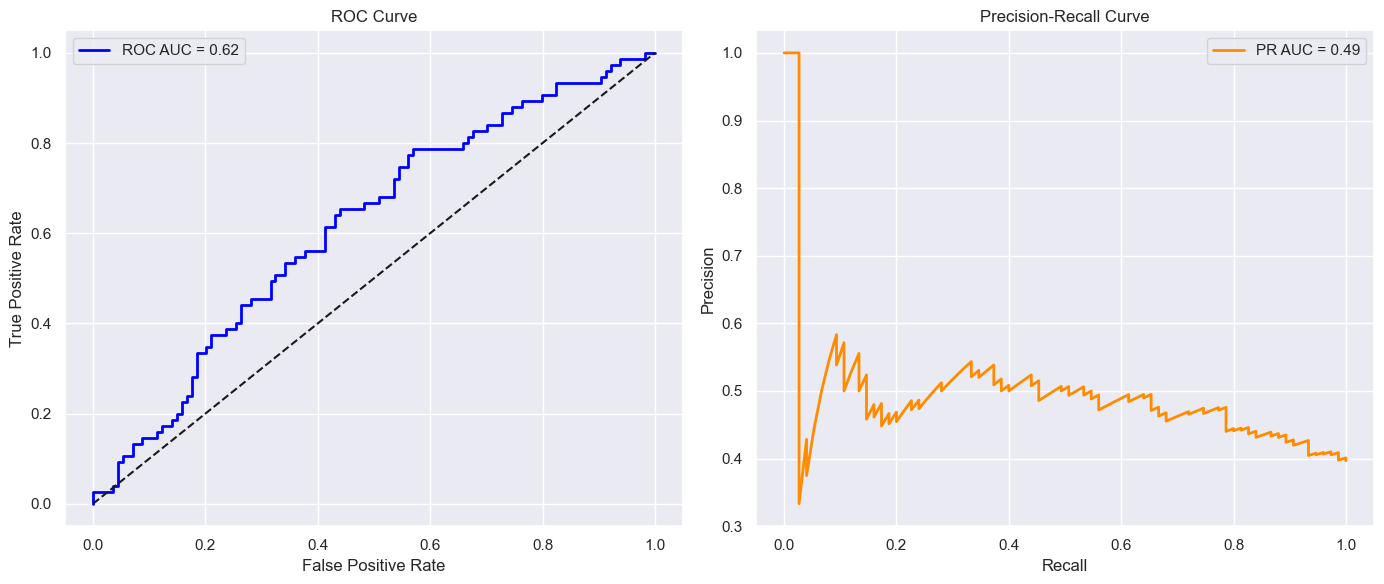


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       101
           1       0.67      0.69      0.68        88

    accuracy                           0.70       189
   macro avg       0.70      0.70      0.70       189
weighted avg       0.70      0.70      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7538253825382538
PR AUC: 0.702898278421177


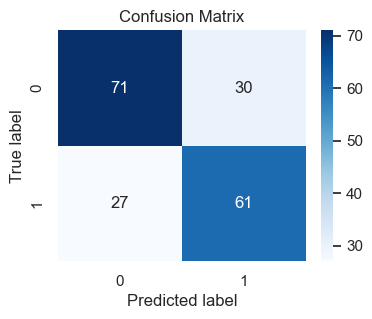

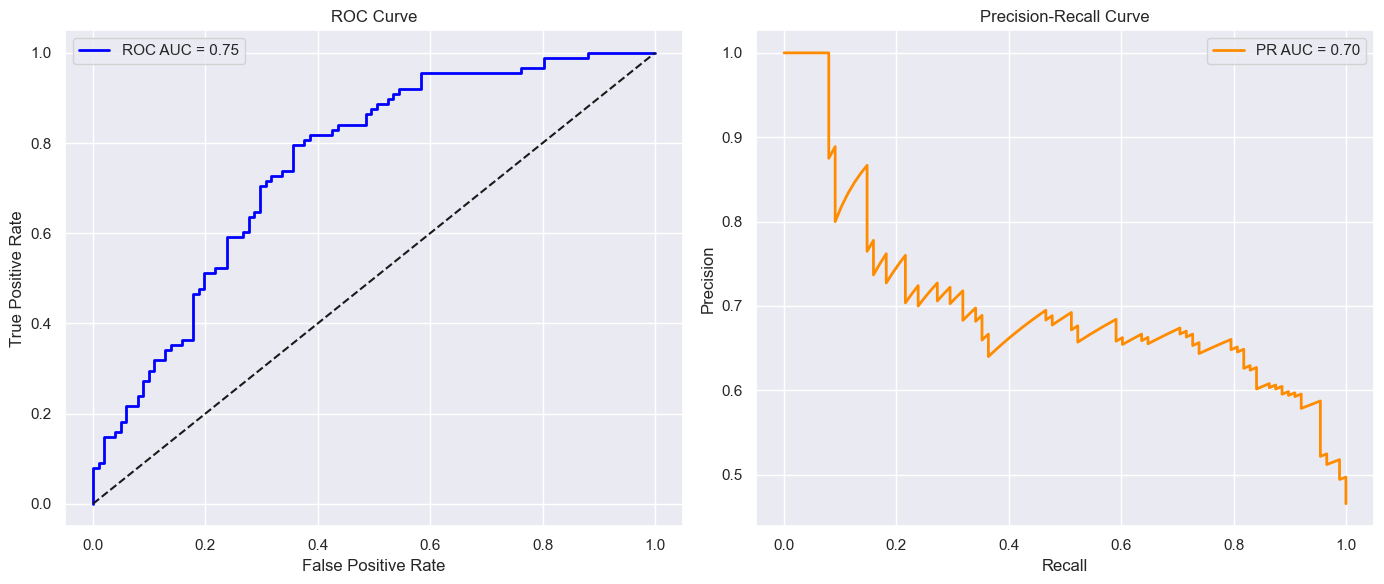

In [23]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)

calculate_evaluation_metrics(knn, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_bin = knn_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.72      0.56      0.63        88
           1       0.47      0.59      0.52        75
           2       0.52      0.54      0.53        26

    accuracy                           0.57       189
   macro avg       0.57      0.56      0.56       189
weighted avg       0.59      0.57      0.57       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7639530096548066
PR AUC: 0.5982454400321617


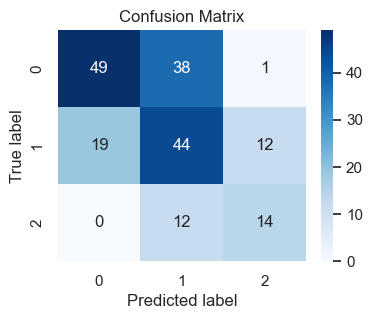

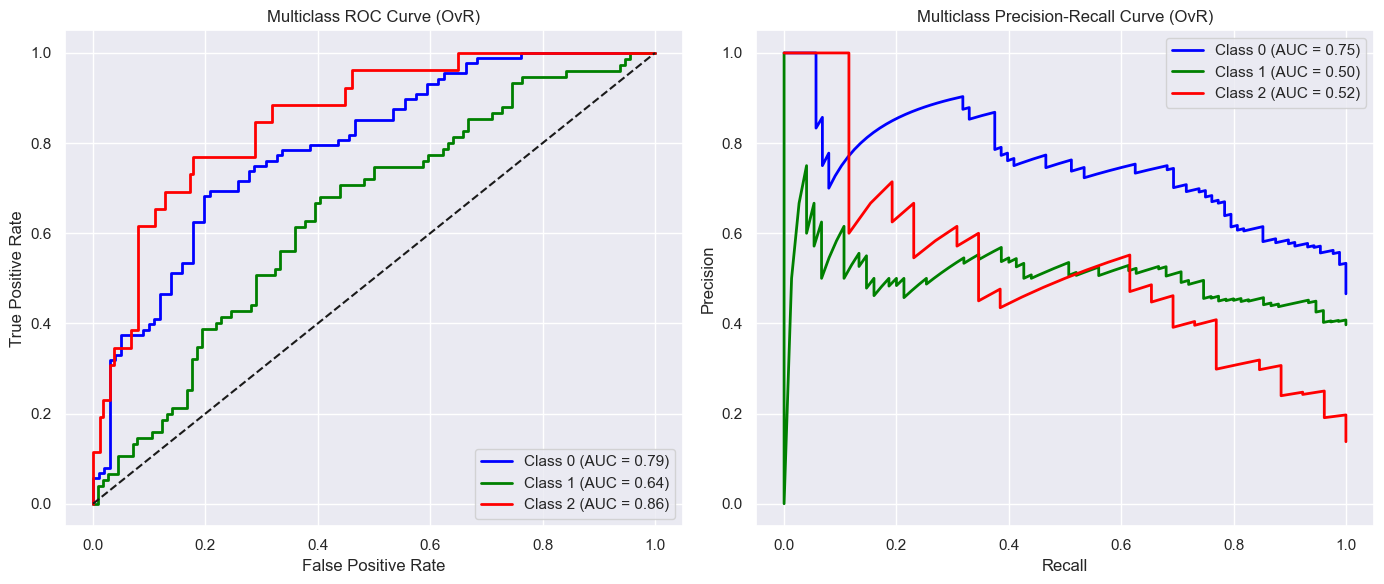


Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       163
           1       0.73      0.31      0.43        26

    accuracy                           0.89       189
   macro avg       0.81      0.64      0.69       189
weighted avg       0.88      0.89      0.87       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7852760736196319
PR AUC: 0.512478706602467


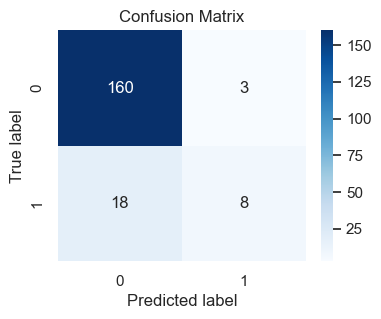

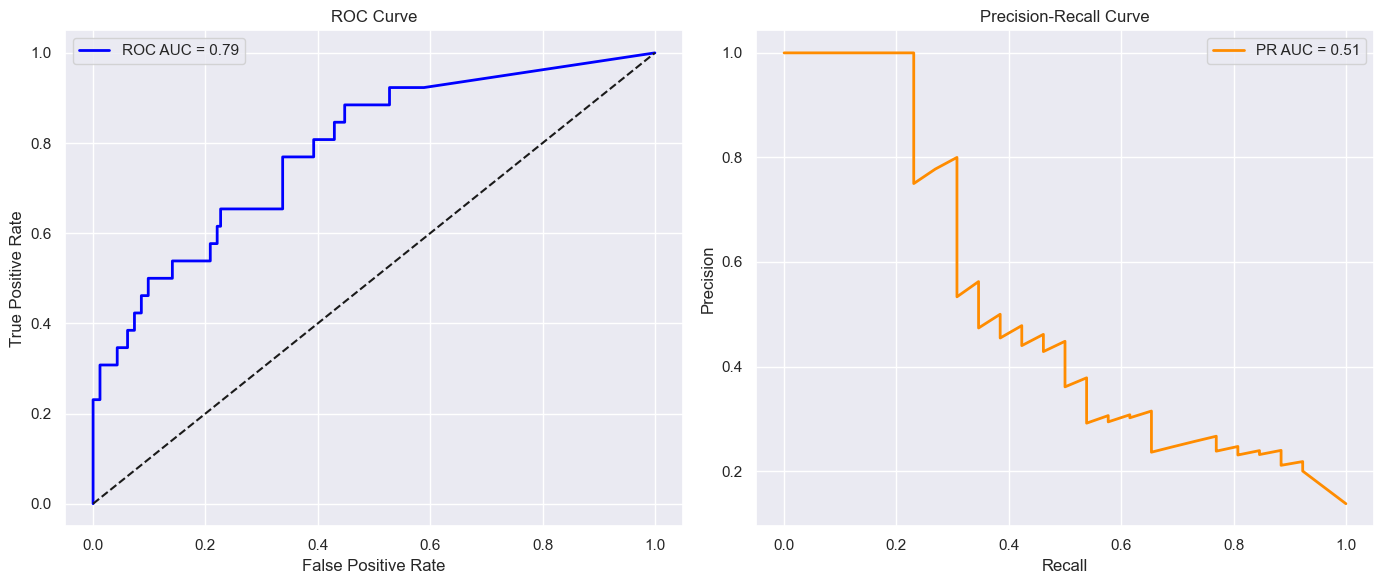


Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.67      0.60      0.63       114
           1       0.48      0.56      0.52        75

    accuracy                           0.58       189
   macro avg       0.58      0.58      0.57       189
weighted avg       0.60      0.58      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6168421052631579
PR AUC: 0.49727155495255404


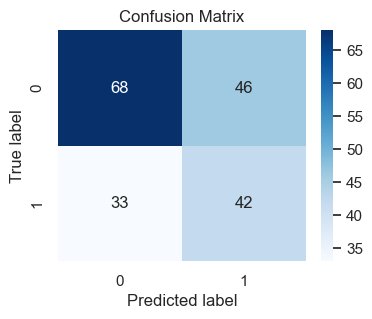

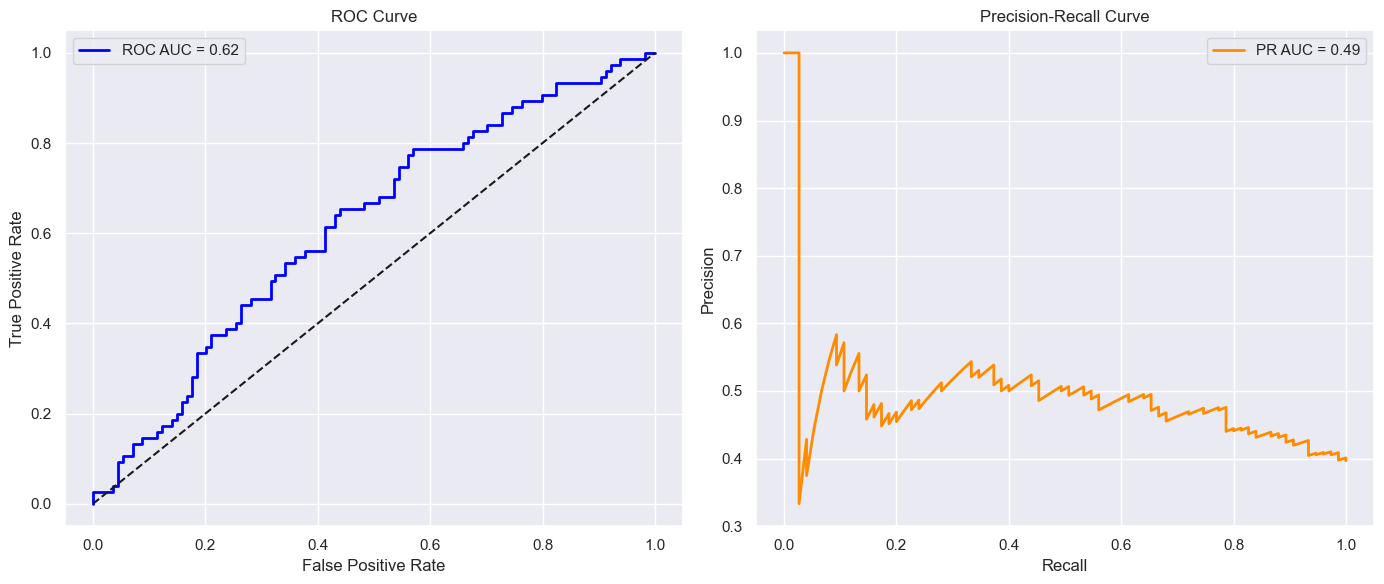


Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.80      0.54      0.65       101
           1       0.62      0.84      0.71        88

    accuracy                           0.68       189
   macro avg       0.71      0.69      0.68       189
weighted avg       0.71      0.68      0.68       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7538253825382538
PR AUC: 0.702898278421177


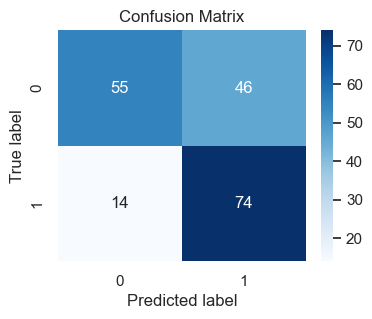

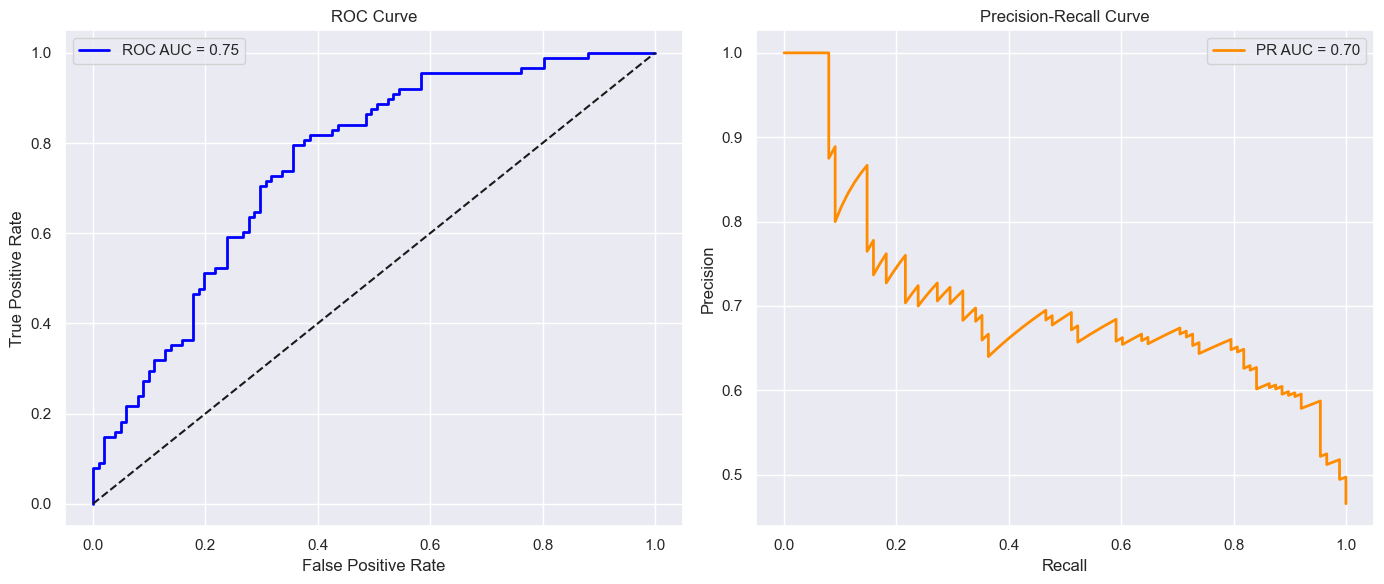

In [24]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])
ovr = OneVsRestClassifier(knn)
ovr.fit(X_train, y_train)

y_pred_proba = ovr.predict_proba(X_test)

custom_preds = []
for probs in y_pred_proba:
    if probs[2] >= 0.2:        
        custom_preds.append(2)
    elif probs[1] >= 0.35:      
        custom_preds.append(1)
    else:
        custom_preds.append(0) 
        
y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)

calculate_evaluation_metrics(ovr, y_test, custom_preds, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    knn_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_bin.fit(X_train_bin, y_train_bin)

    y_pred_proba_bin = knn_bin.predict_proba(X_test_bin)
    y_pred_bin = (y_pred_proba_bin[:,1] >= 0.4).astype(int)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
Player_class_num
1    351
0    351
2    351
Name: count, dtype: int64

=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.73      0.72        88
           1       0.52      0.40      0.45        75
           2       0.40      0.62      0.48        26

    accuracy                           0.58       189
   macro avg       0.54      0.58      0.55       189
weighted avg       0.59      0.58      0.58       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7367615953203411
PR AUC: 0.5817024810086747


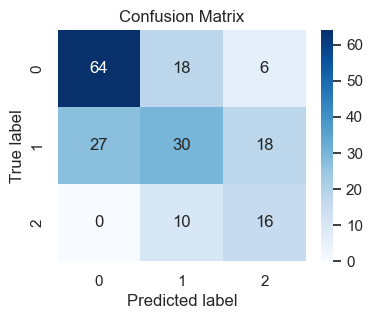

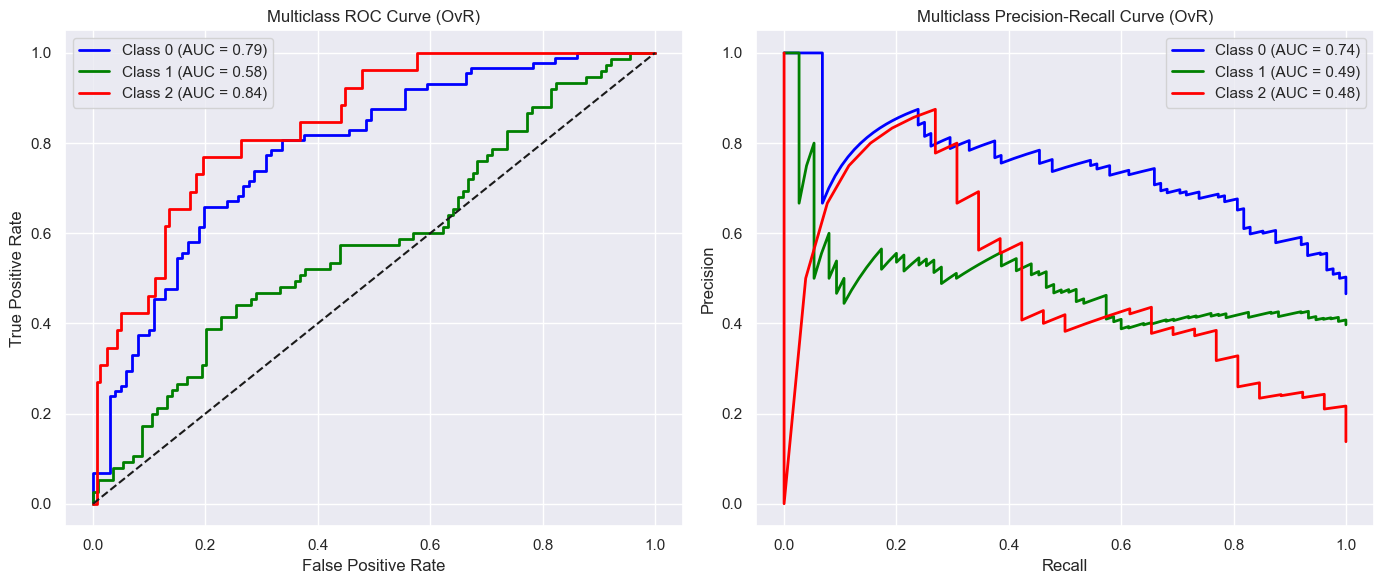

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
all-star_class
0    651
1    651
Name: count, dtype: int64

Binary classification results: all-star vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.94      0.72      0.82       163
           1       0.29      0.73      0.42        26

    accuracy                           0.72       189
   macro avg       0.62      0.72      0.62       189
weighted avg       0.85      0.72      0.76       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7869277961302501
PR AUC: 0.4407150887695686


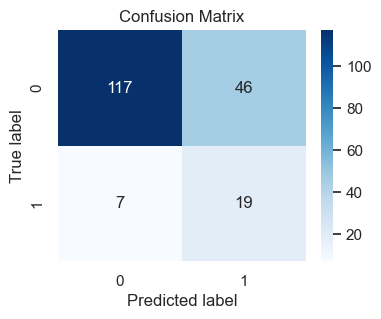

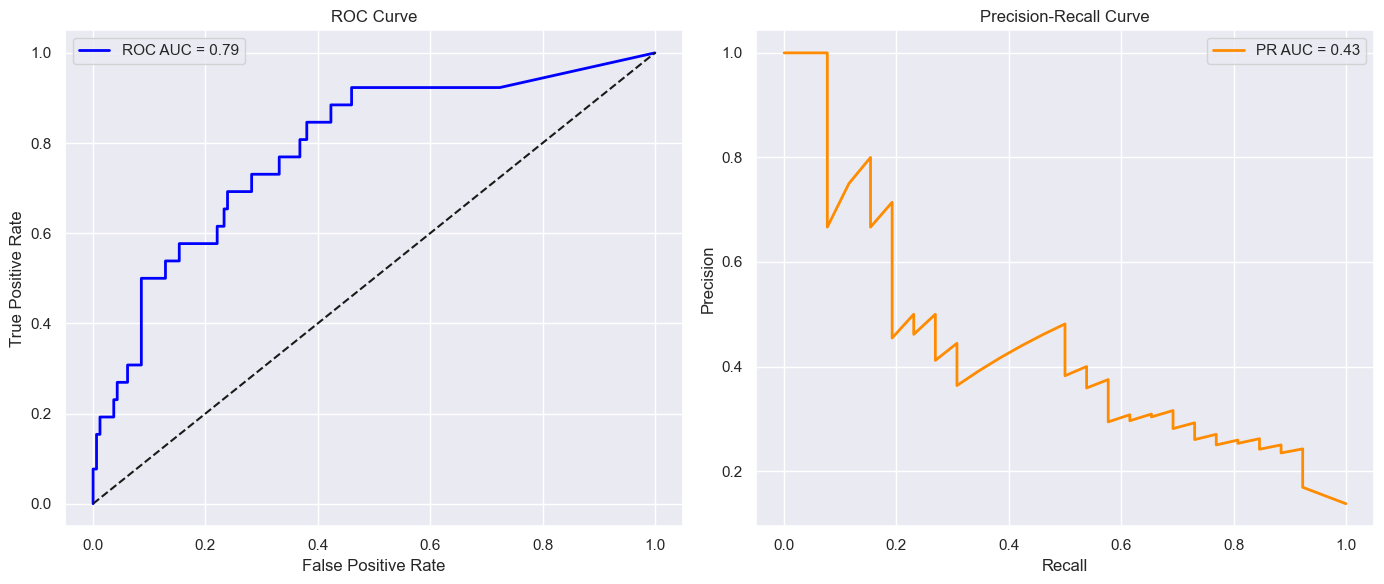

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
starter_class
1    453
0    453
Name: count, dtype: int64

Binary classification results: starter vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.69      0.56      0.62       114
           1       0.48      0.61      0.54        75

    accuracy                           0.58       189
   macro avg       0.58      0.59      0.58       189
weighted avg       0.61      0.58      0.59       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.6061988304093568
PR AUC: 0.4825828814486516


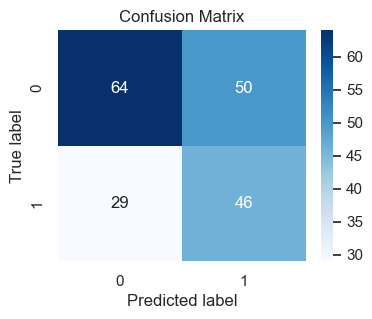

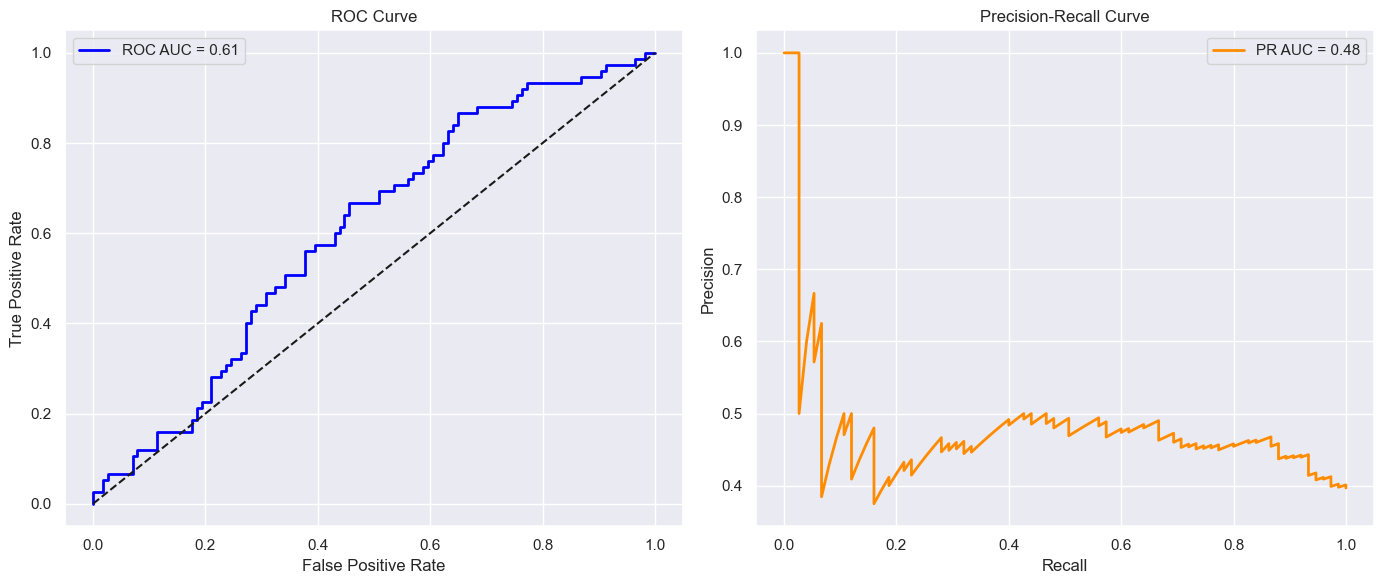

Number of elements in each class:
Player_class_num
0    351
1    300
2    102
Name: count, dtype: int64

Number of elements in each class after sampling:
bench_class
1    402
0    402
Name: count, dtype: int64

Binary classification results: bench vs. others


=== Classification Report ===
               precision    recall  f1-score   support

           0       0.78      0.62      0.69       101
           1       0.65      0.80      0.71        88

    accuracy                           0.70       189
   macro avg       0.71      0.71      0.70       189
weighted avg       0.72      0.70      0.70       189


=== ROC AUC and PR AUC values ===
ROC AUC: 0.7574257425742574
PR AUC: 0.705837251194824


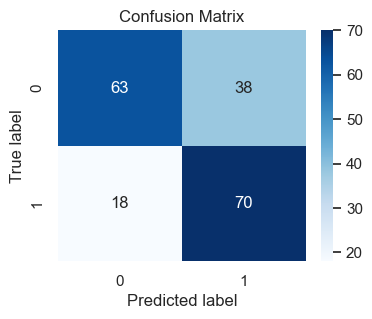

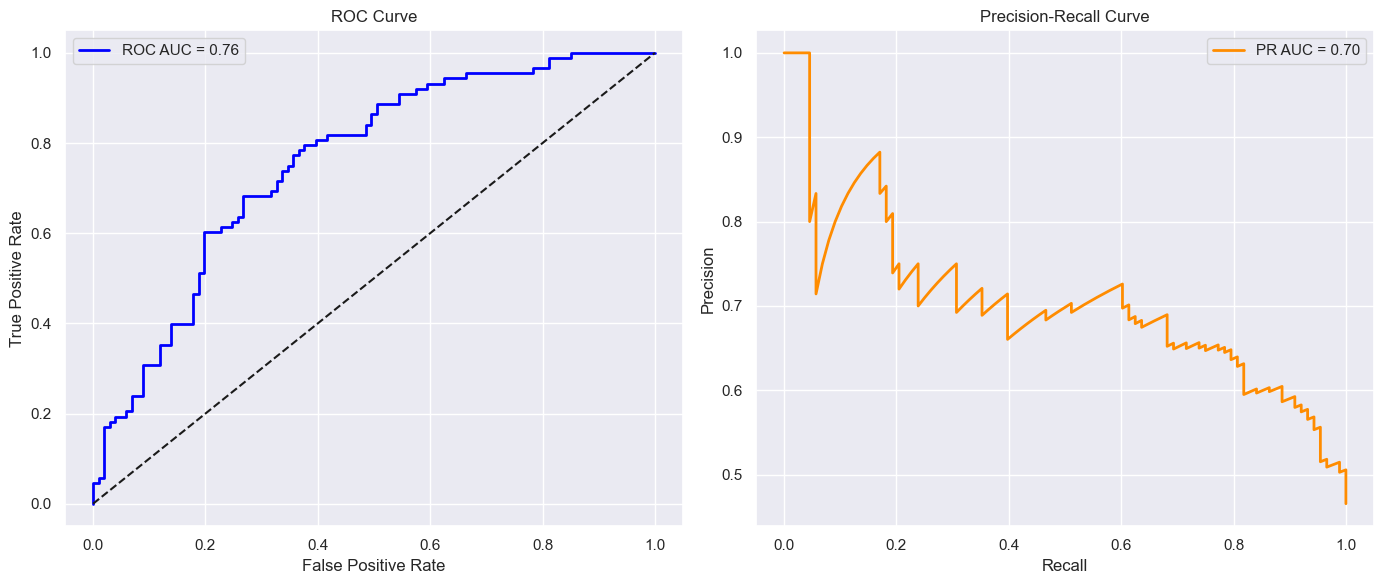

In [25]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print('Number of elements in each class:')
print(y_train.value_counts())
print('\nNumber of elements in each class after sampling:')
print(pd.Series(y_res).value_counts())

knn_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=48, weights='distance'))
])

knn_smote.fit(X_res, y_res)

y_pred = knn_smote.predict(X_test)
y_pred_proba = knn_smote.predict_proba(X_test)

calculate_evaluation_metrics(knn_smote, y_test, y_pred, y_pred_proba)

for class_num, class_label in zip([2, 1, 0], ["all-star", "starter", "bench"]):
    df_bin = final_dataset_1_seasons.copy()
    df_bin[f'{class_label}_class'] = df_bin['Player_class_num'].apply(lambda x: 1 if x == class_num else 0)

    X_bin = df_bin.drop(columns=['Player_class_num', f'{class_label}_class'])
    y_bin = df_bin[f'{class_label}_class']

    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin)
    
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train_bin, y_train_bin)

    print('Number of elements in each class:')
    print(y_train.value_counts())
    print('\nNumber of elements in each class after sampling:')
    print(pd.Series(y_res).value_counts())

    knn_smote_bin = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=17, weights='distance'))
    ])

    knn_smote_bin.fit(X_res, y_res)

    y_pred_bin = knn_smote_bin.predict(X_test_bin)
    y_pred_proba_bin = knn_smote_bin.predict_proba(X_test_bin)

    print(f"\nBinary classification results: {class_label} vs. others\n")
    calculate_evaluation_metrics(knn_smote_bin, y_test_bin, y_pred_bin, y_pred_proba_bin)